<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%201Q%20DD%20(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 10.9 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# CP CPMG UDD XY4 XY8 XY16 Sequence

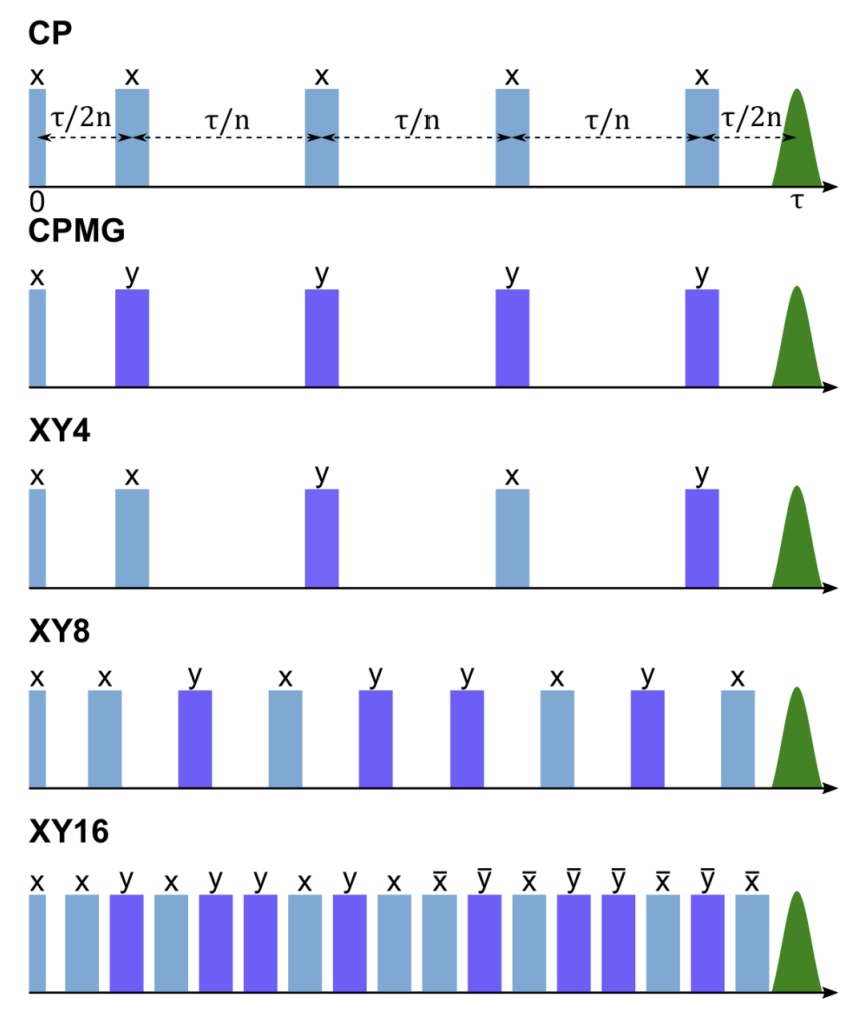

In [3]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [4]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [5]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

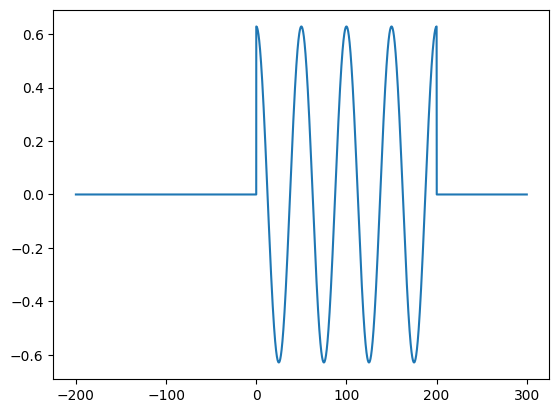

In [6]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [7]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [8]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [9]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

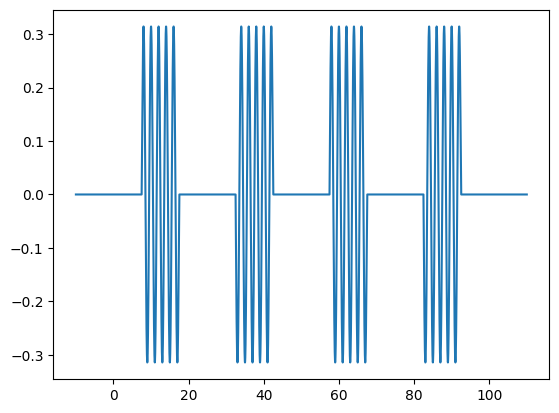

In [10]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

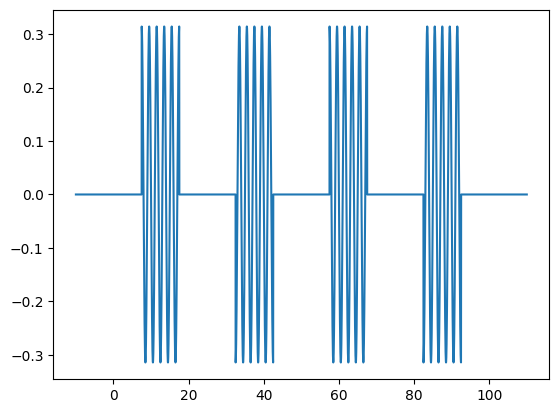

In [11]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

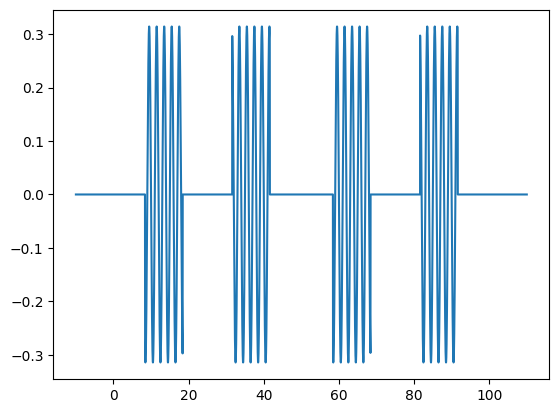

In [12]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

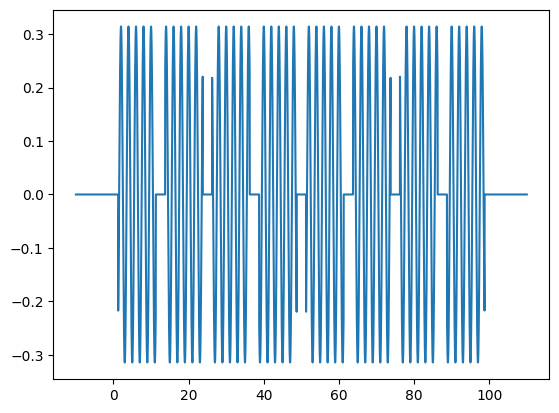

In [13]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

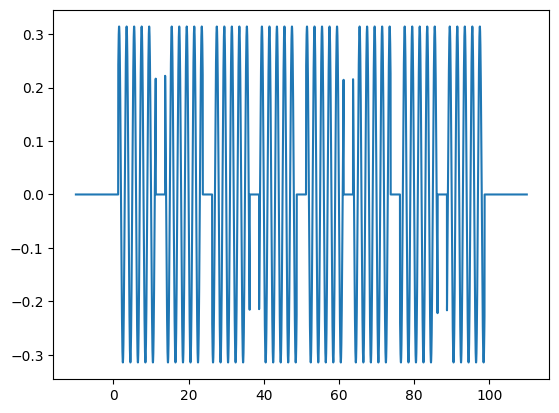

In [14]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

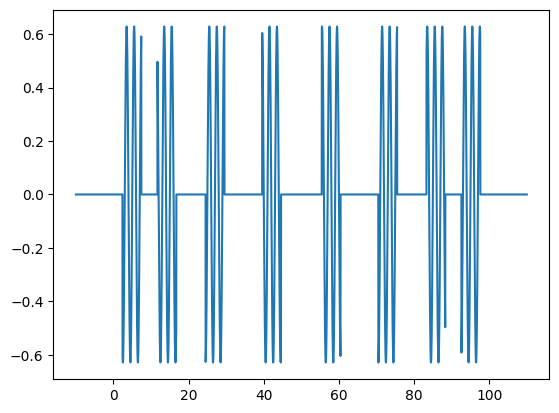

In [15]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [16]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [17]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [18]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

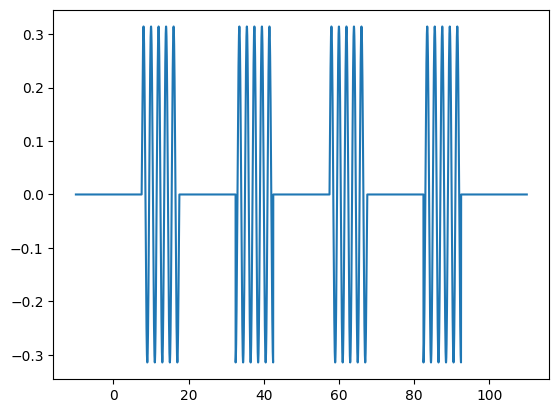

In [19]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

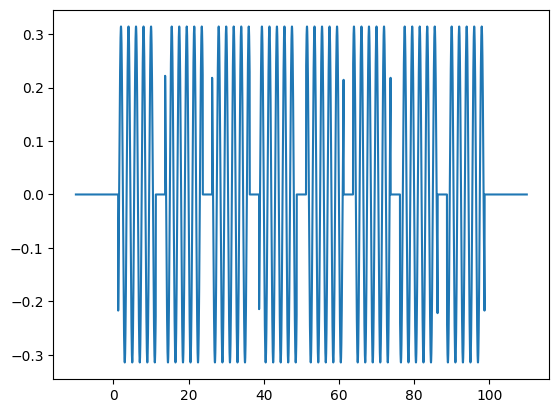

In [20]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

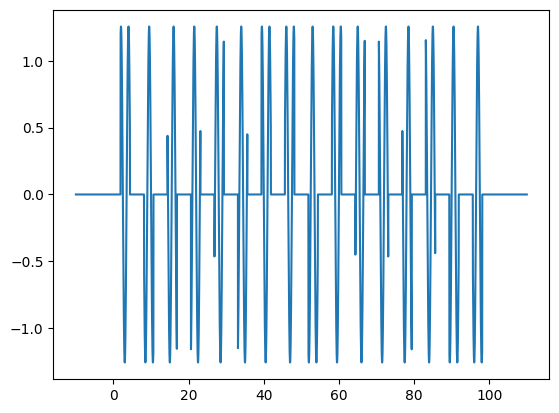

In [21]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [22]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [23]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [24]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

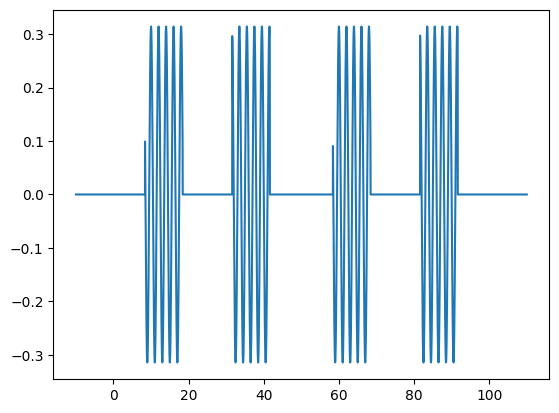

In [25]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

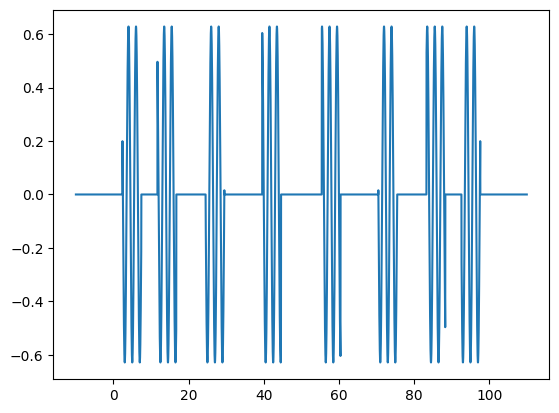

In [26]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

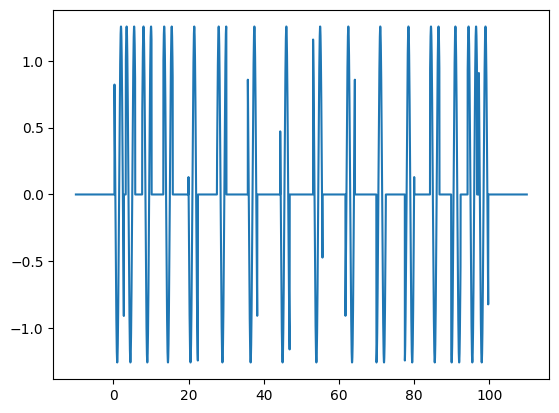

In [27]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Goal of this paper

Goal : Investigate the effect of dynamical decoupling

Total evolution time : 500ns, 1000ns

Condition 1 : large photon number regime $ n = 0.005 $

Condition 2 : without Purcell Filter

# Ramsey Simulation & Coherence Signal Analysis

Without Purcell Filter

Evolution time 500ns

## Ramsey (A = 0 GHz)

In [198]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0 * 2 * np.pi
B = 0.1 * 2 * np.pi

In [199]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004348998234429389


Text(0, 0.5, 'Z Expectation Value')

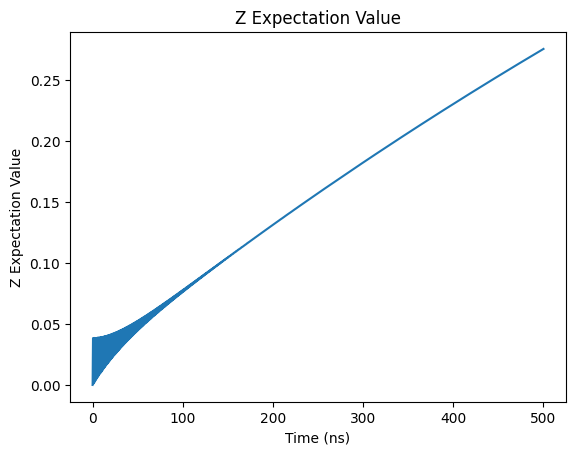

In [200]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [201]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.66488803e-01,  9.85712459e-01,  1.61994919e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

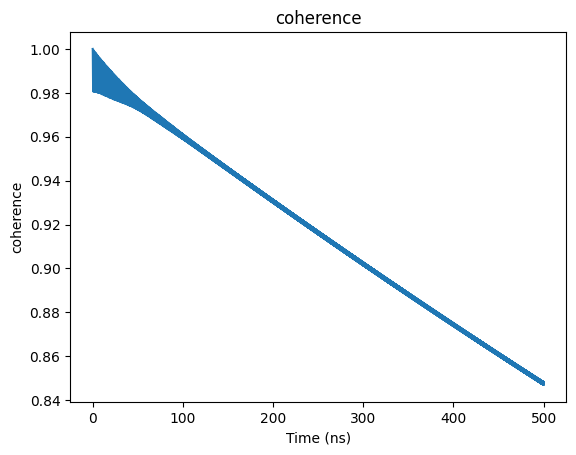

In [202]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

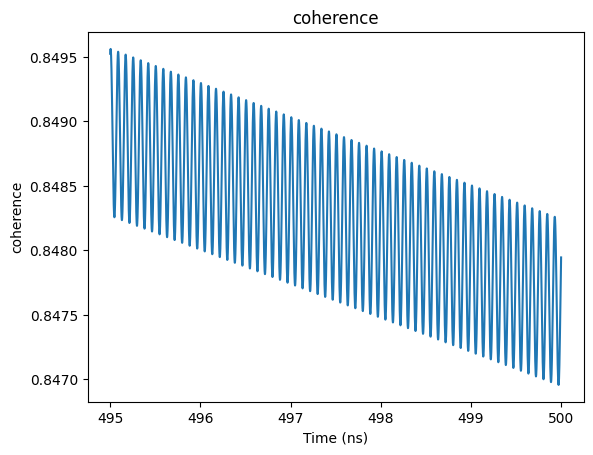

In [203]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

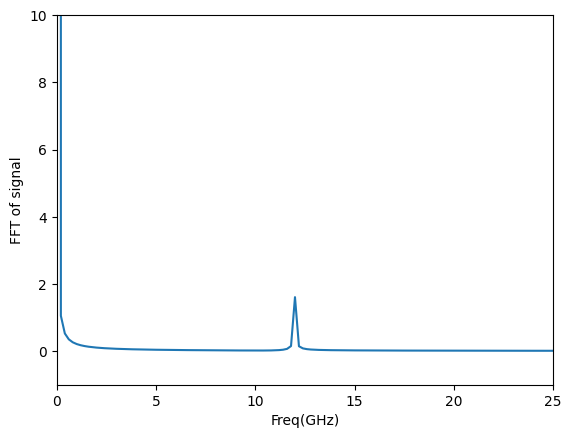

In [204]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

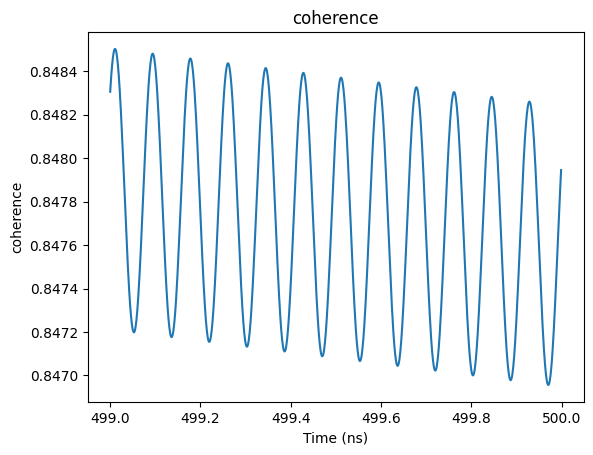

In [205]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

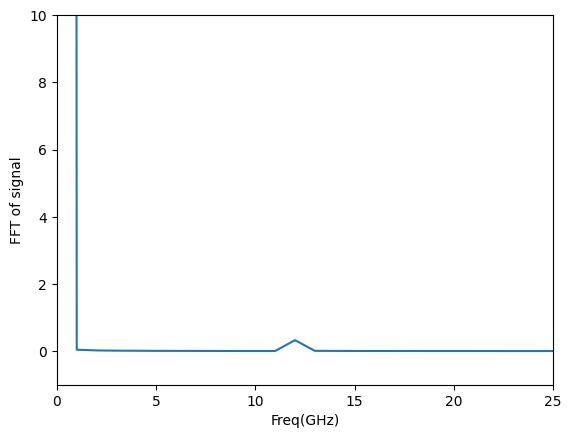

In [206]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

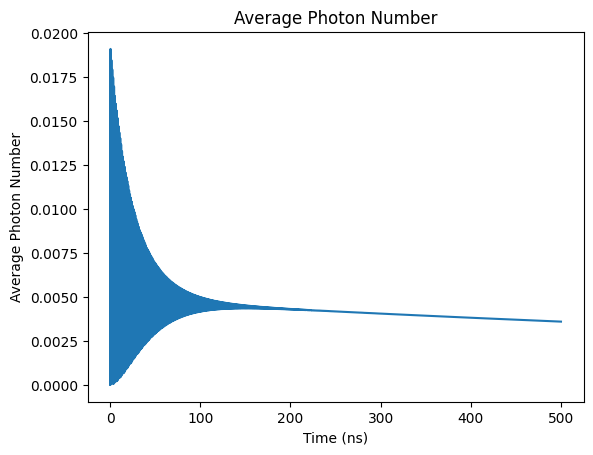

In [207]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

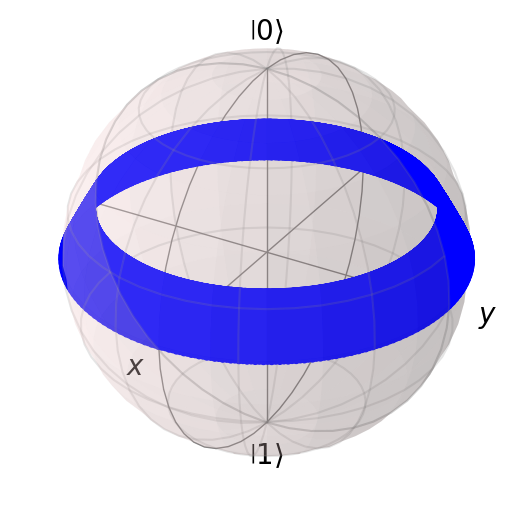

In [208]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.000001 GHz)

In [141]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.000001 * 2 * np.pi
B = 0.1 * 2 * np.pi

In [142]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004349122882751366


Text(0, 0.5, 'Z Expectation Value')

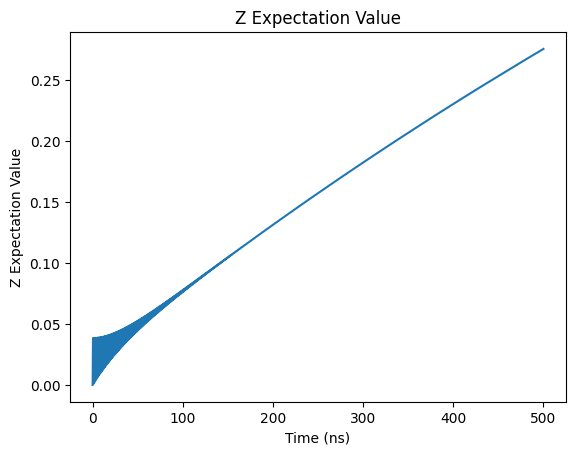

In [143]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [144]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.66487530e-01,  9.85711065e-01,  1.61994635e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

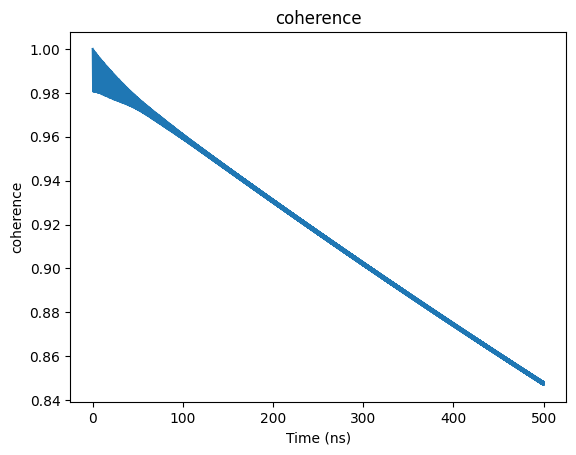

In [145]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

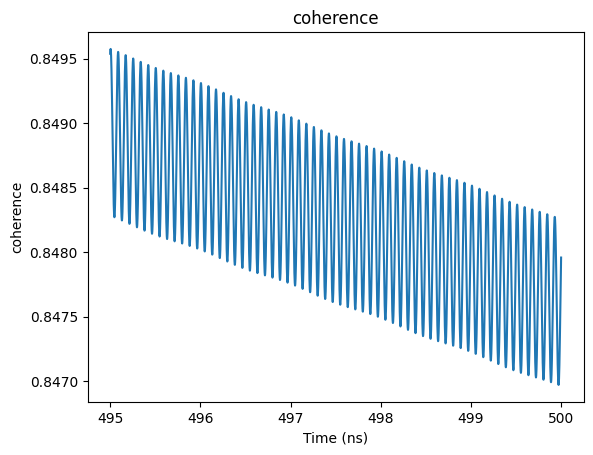

In [146]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

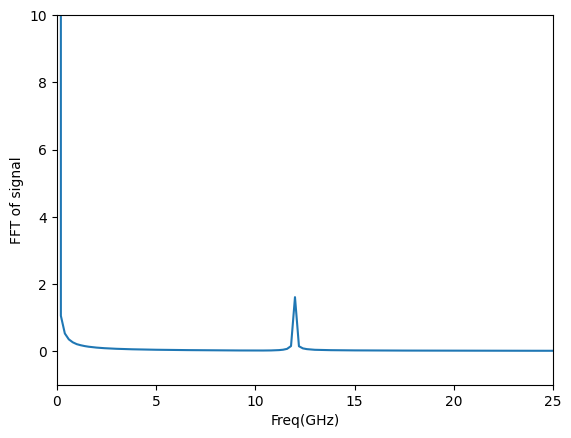

In [147]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

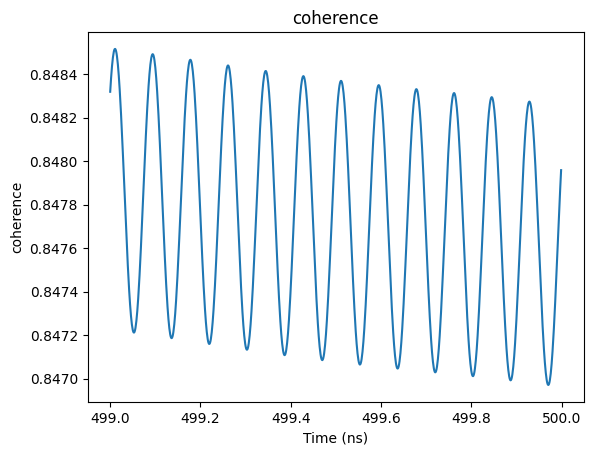

In [148]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

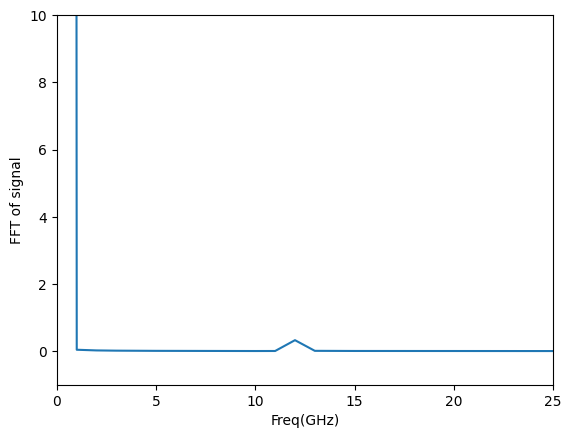

In [149]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

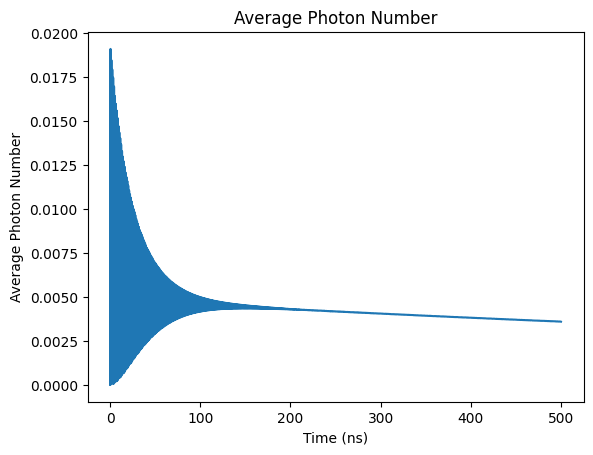

In [150]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

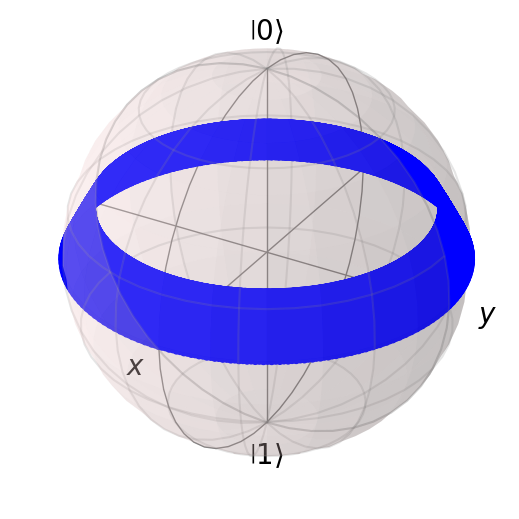

In [151]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.00001 GHz)

In [152]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.00001 * 2 * np.pi
B = 0.1 * 2 * np.pi

In [153]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004350456628458265


Text(0, 0.5, 'Z Expectation Value')

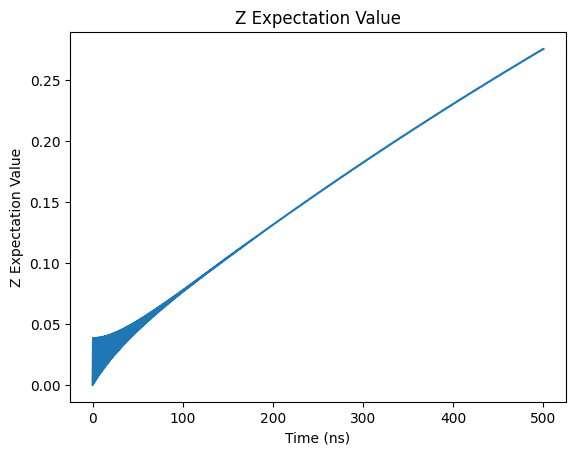

In [154]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [155]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.66476064e-01,  9.85698511e-01,  1.61992085e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

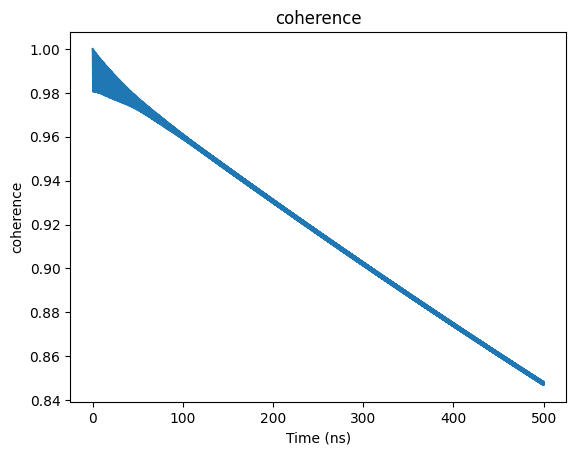

In [156]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

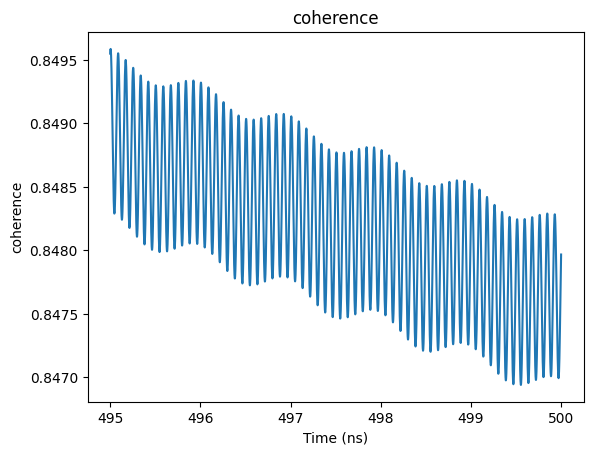

In [157]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

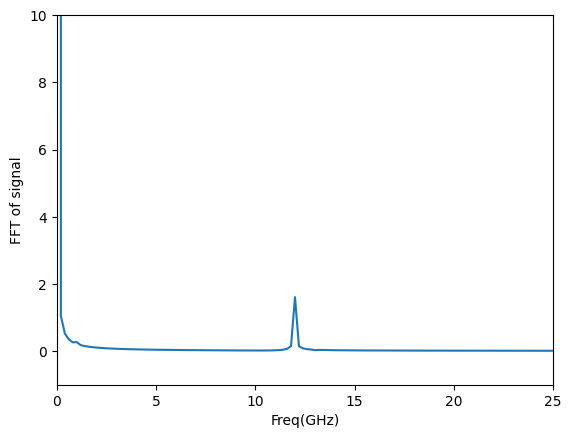

In [158]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

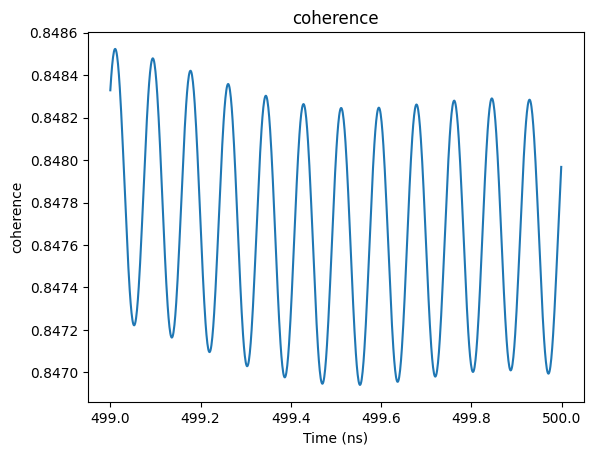

In [159]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

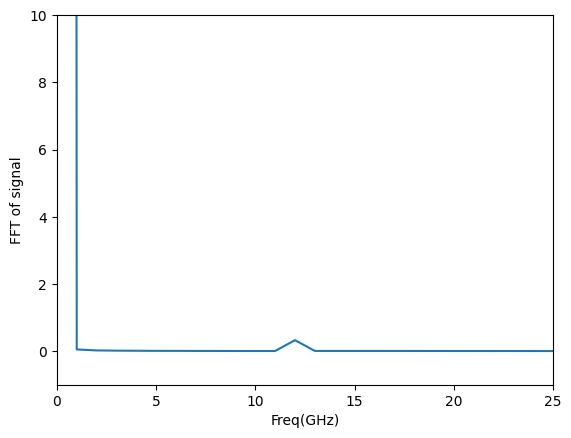

In [160]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

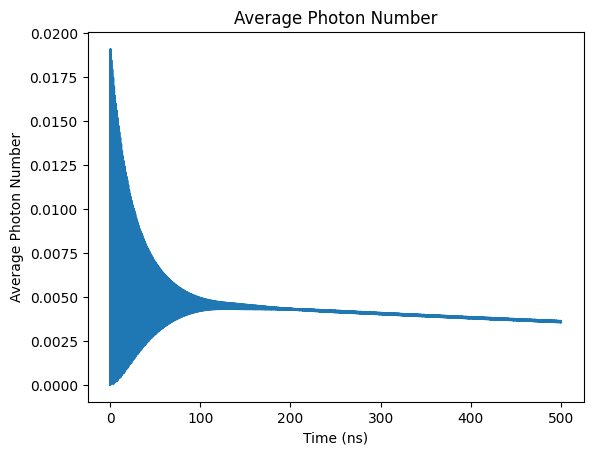

In [161]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

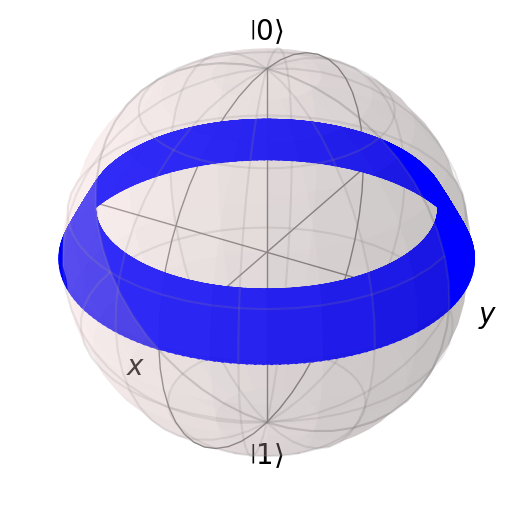

In [162]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.0001 GHz)

In [130]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0001 * 2 * np.pi
B = 0.1 * 2 * np.pi

In [131]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004384771739735881


Text(0, 0.5, 'Z Expectation Value')

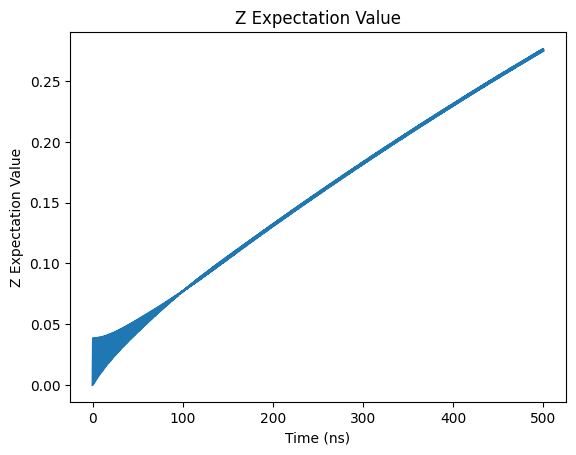

In [132]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [133]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.66361683e-01,  9.85573241e-01,  1.61966888e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

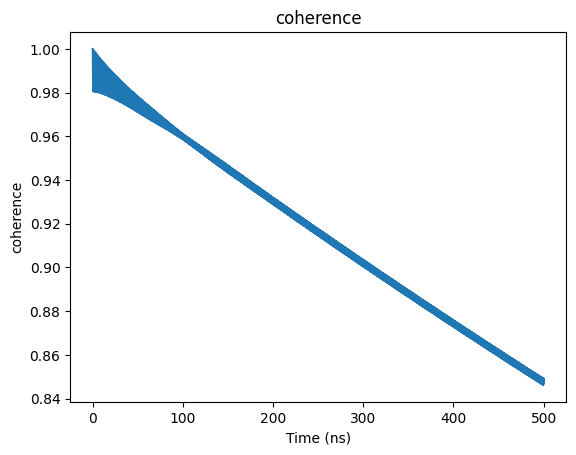

In [134]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

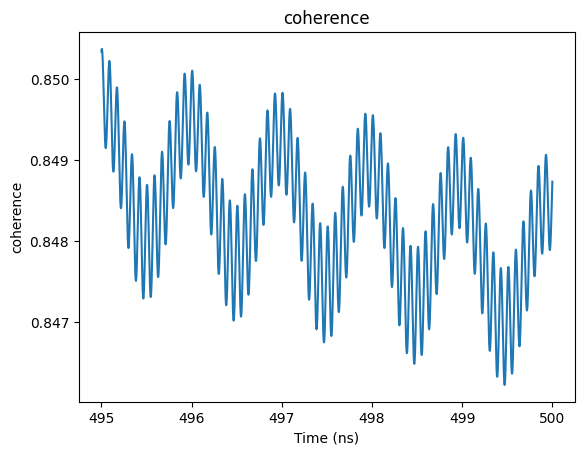

In [135]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

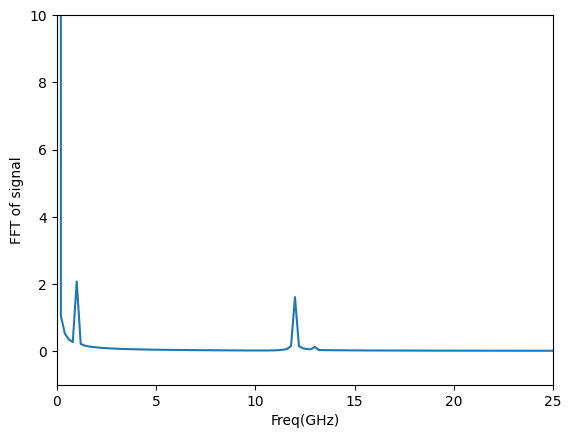

In [136]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

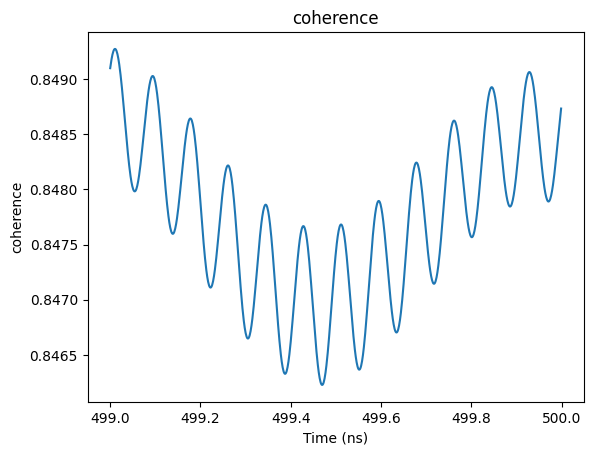

In [137]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

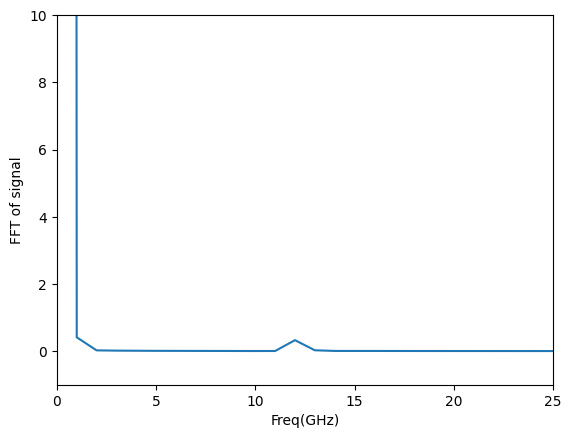

In [138]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

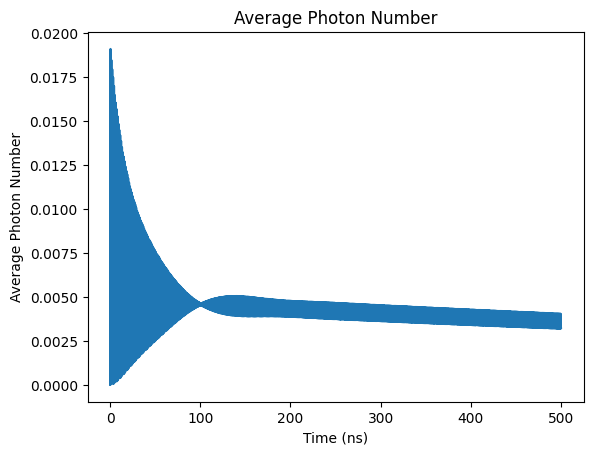

In [139]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

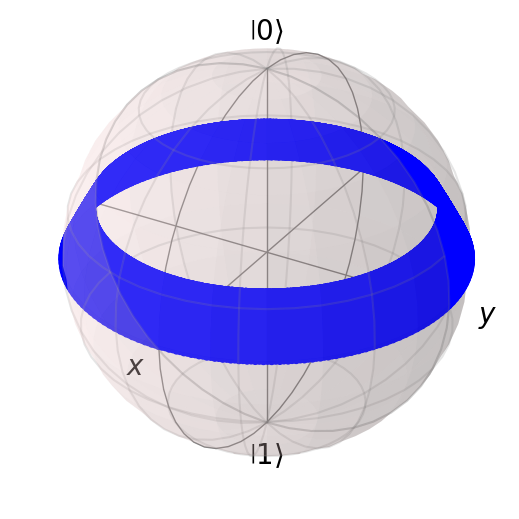

In [140]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.001 GHz)

In [163]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.001 * 2 * np.pi
B = 0.1 * 2 * np.pi

In [164]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.006825913873091004


Text(0, 0.5, 'Z Expectation Value')

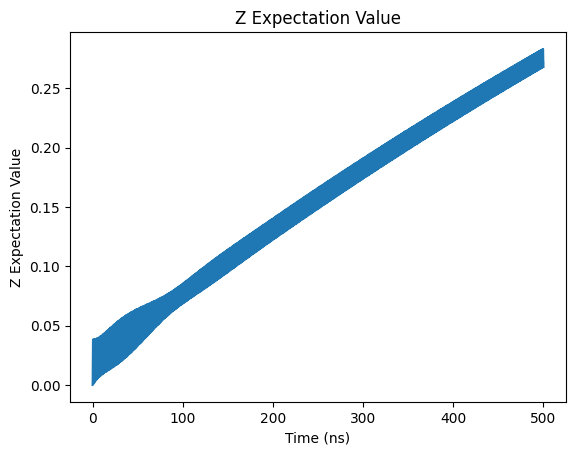

In [165]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [166]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.65311407e-01,  9.84413237e-01,  1.61757887e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

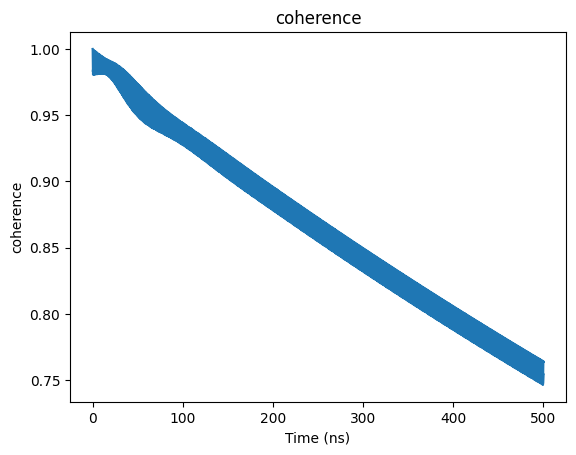

In [167]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

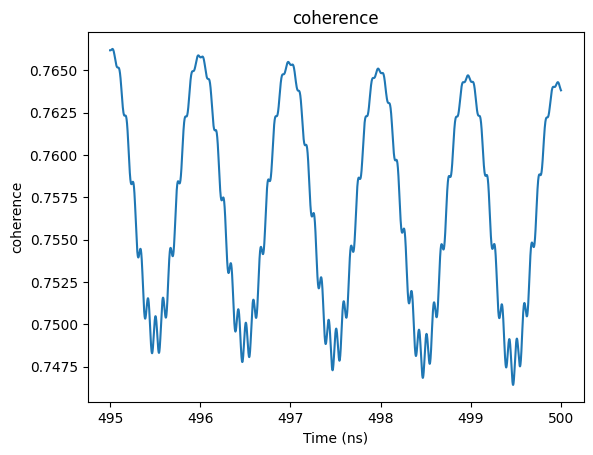

In [168]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

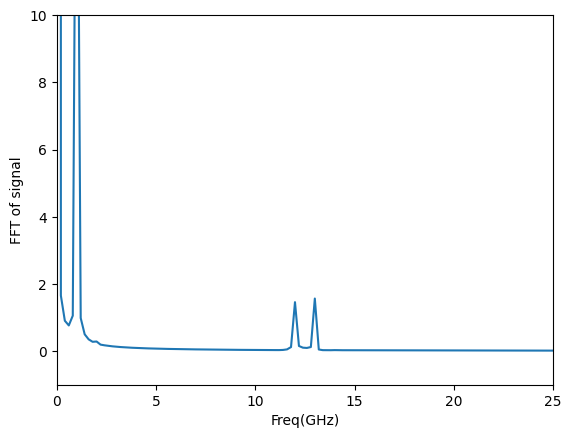

In [169]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

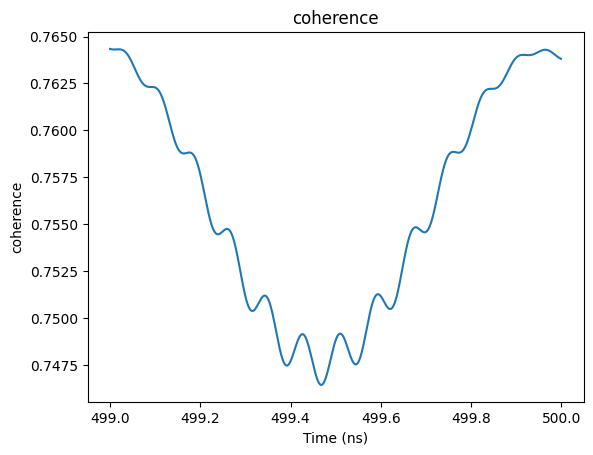

In [170]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

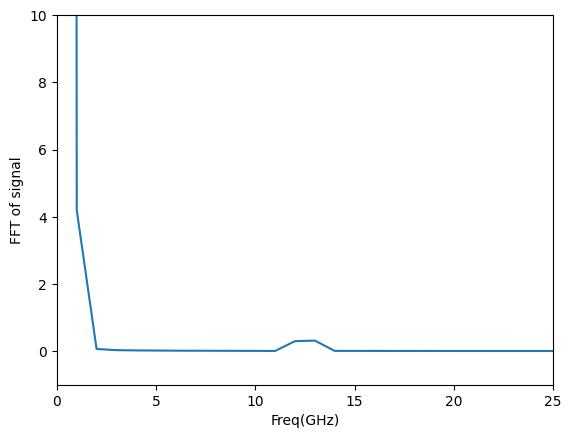

In [171]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

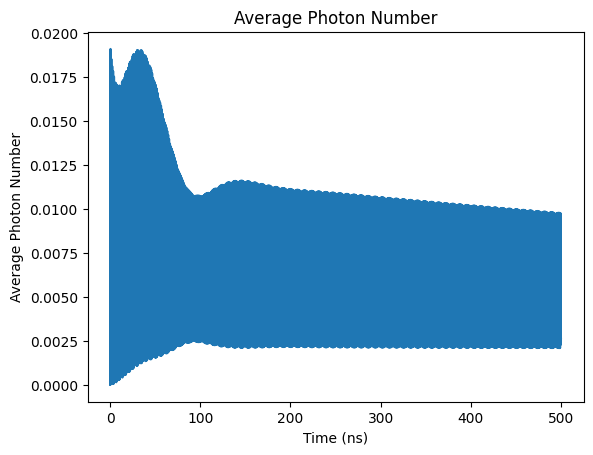

In [172]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

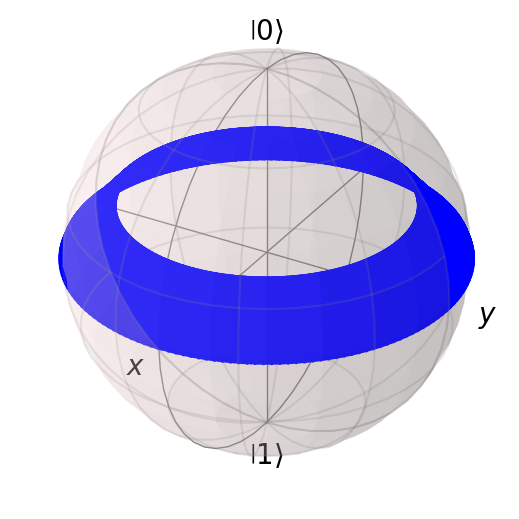

In [173]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

# Ramsey Simulation & Photon Number Calculation

With Purcell Filter

Evolution time 500ns

In [210]:
A_list = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]

In [47]:
n_list = []

In [211]:
n_list

[0.00798522851099307,
 0.008004399744174856,
 0.00836499926305596,
 0.0099214351470651,
 0.01404443850917891,
 0.022463949674930914,
 0.03694191539012318,
 0.05876942996147742,
 0.08822084696907329,
 0.12424001012449509,
 0.1645887758015602,
 0.2075442368201584,
 0.24823480383925112,
 0.2857583013724545,
 0.31901806526561194,
 0.3476606670828996,
 0.37184187170765504,
 0.3919979605206599,
 0.40867390411747684,
 0.42242771423260345]

[0.00798522851099307,
 0.008004399744174856,
 0.00836499926305596,
 0.0099214351470651,
 0.01404443850917891,
 0.022463949674930914,
 0.03694191539012318,
 0.05876942996147742,
 0.08822084696907329,
 0.12424001012449509,
 0.1645887758015602,
 0.2075442368201584,
 0.24823480383925112,
 0.2857583013724545,
 0.31901806526561194,
 0.3476606670828996,]

Text(0, 0.5, 'Average Photon Number')

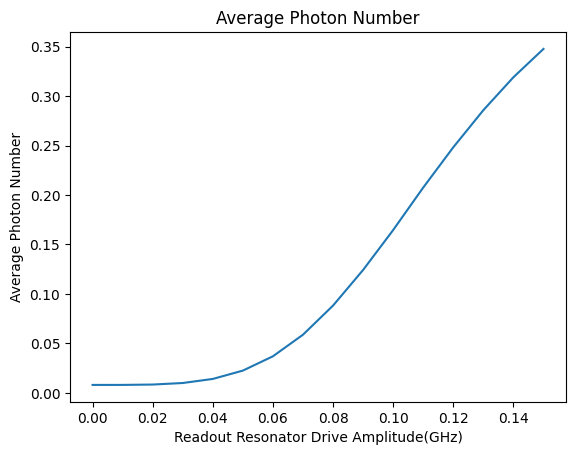

In [213]:
# Plot Results

plt.plot(A_list, n_list[0:16])

plt.title('Average Photon Number')
plt.xlabel('Readout Resonator Drive Amplitude(GHz)')
plt.ylabel('Average Photon Number')

## Ramsey (A = 0 GHz)

In [48]:
# constant
N = 2

A = 0 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [49]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.00798522851099307


Text(0, 0.5, 'Z Expectation Value')

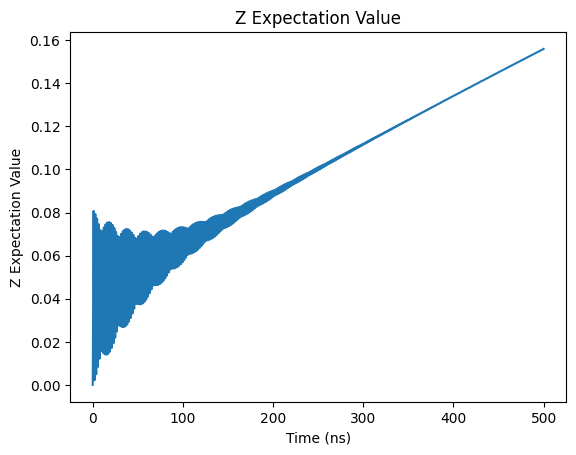

In [50]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [51]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.54845817e-01,  9.95871091e-01,  3.89892242e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

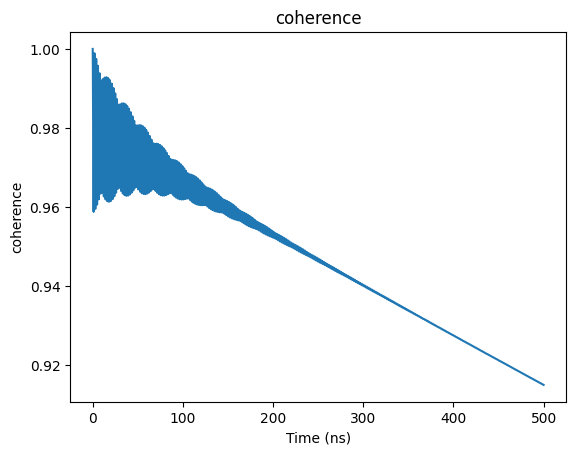

In [52]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

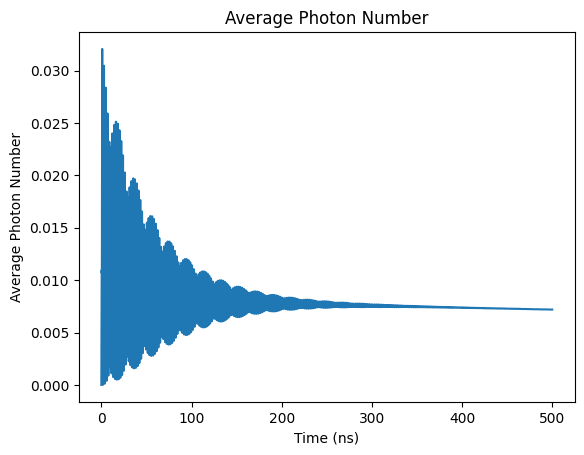

In [53]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

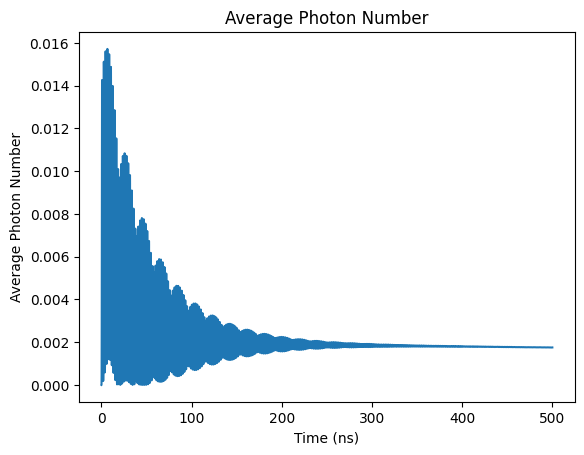

In [54]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

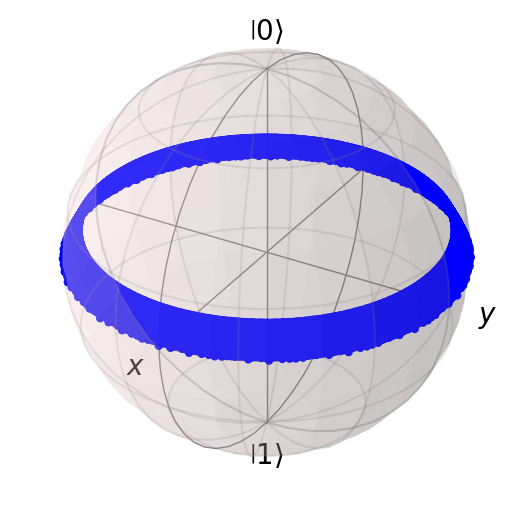

In [55]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.01 GHz)

In [56]:
# constant
N = 2

A = 0.01 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [57]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.008004399744174856


Text(0, 0.5, 'Z Expectation Value')

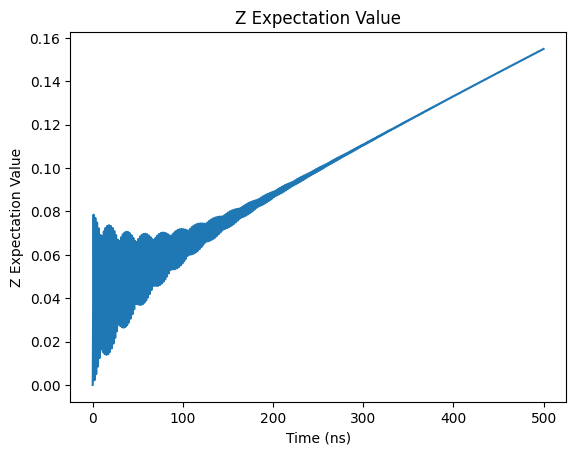

In [58]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [59]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.56644204e-01,  9.96539890e-01,  3.90141427e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

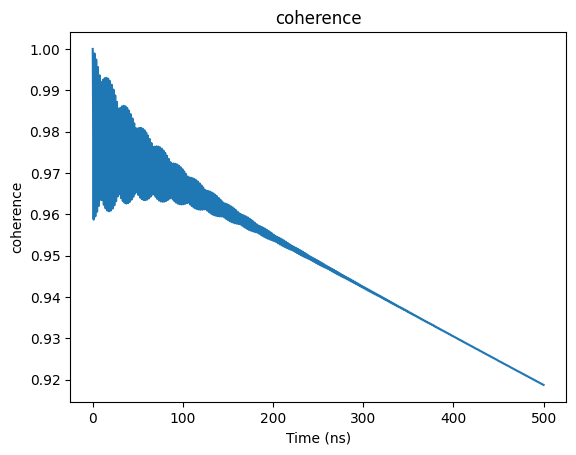

In [60]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

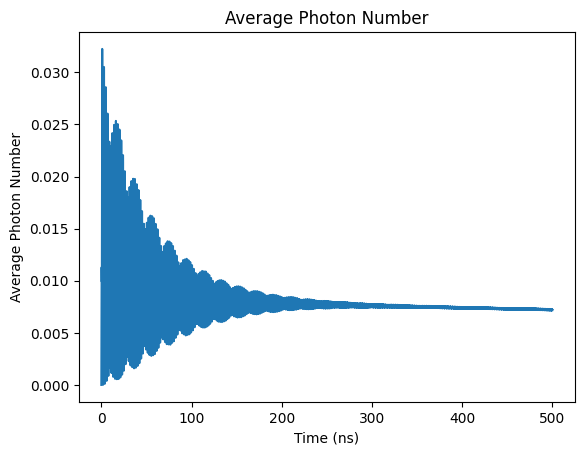

In [61]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

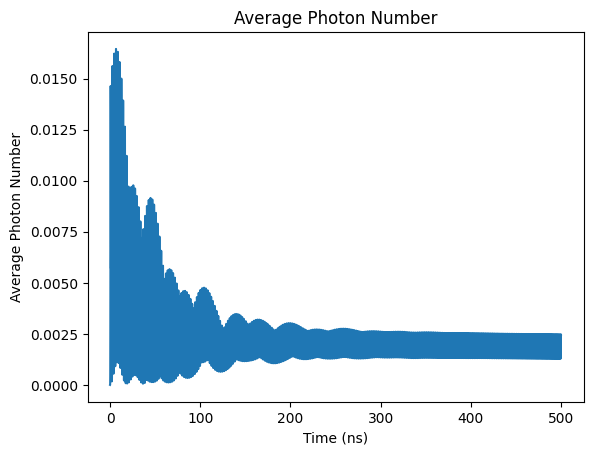

In [62]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

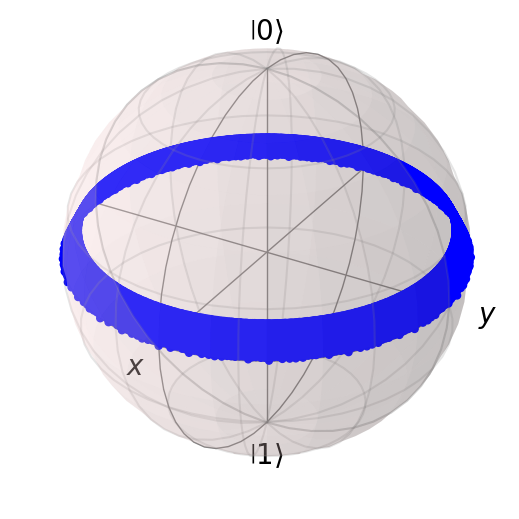

In [63]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.02 GHz)

In [64]:
# constant
N = 2

A = 0.02 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [65]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.00836499926305596


Text(0, 0.5, 'Z Expectation Value')

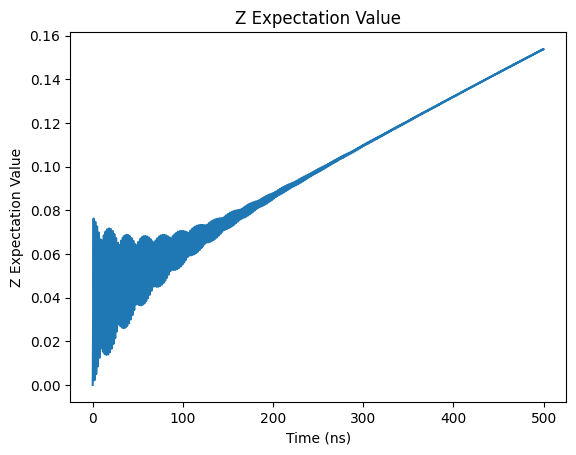

In [66]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [67]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.56593132e-01,  9.95368875e-01,  3.89878561e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

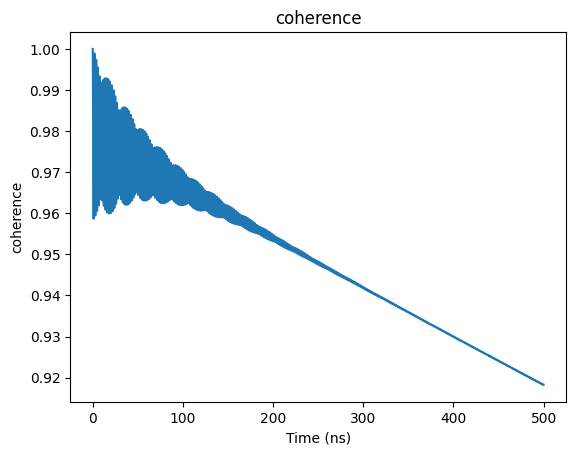

In [68]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

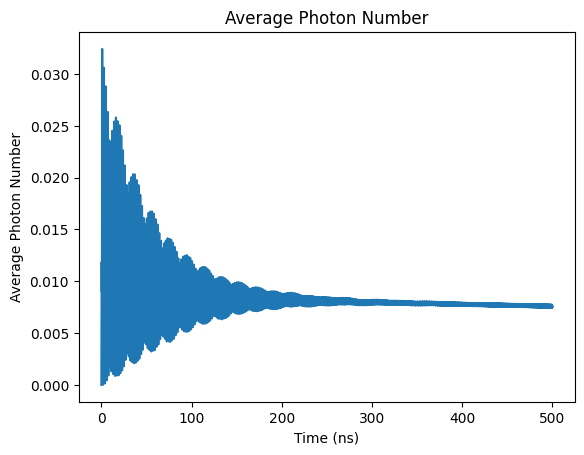

In [69]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

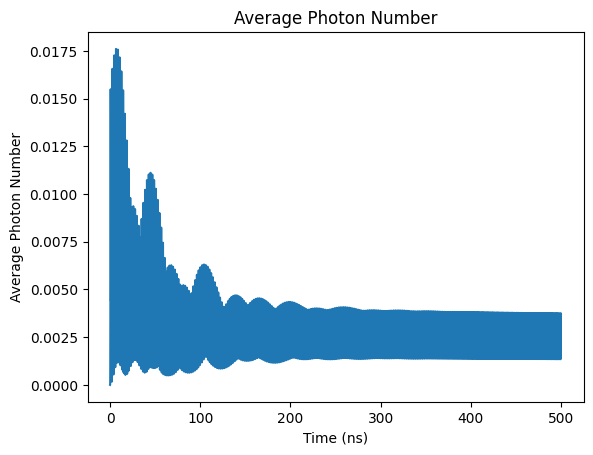

In [70]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

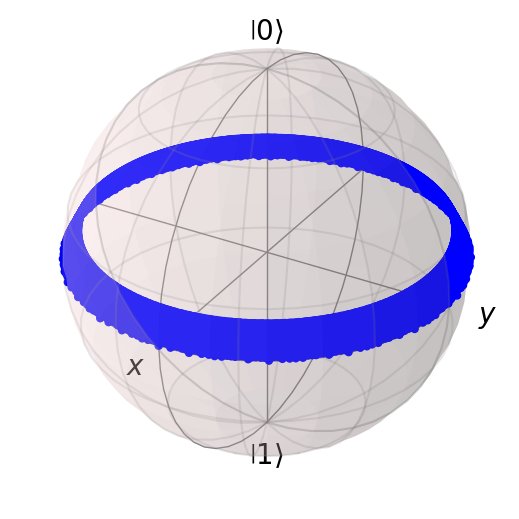

In [71]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.03 GHz)

In [72]:
# constant
N = 2

A = 0.03 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [73]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.0099214351470651


Text(0, 0.5, 'Z Expectation Value')

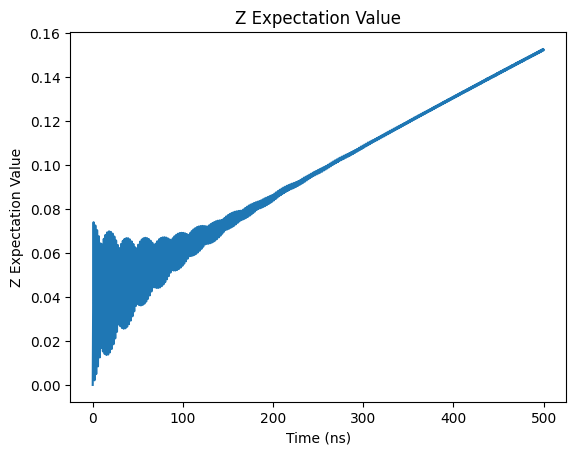

In [74]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [75]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.46442712e-01,  9.84081877e-01,  3.86822263e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

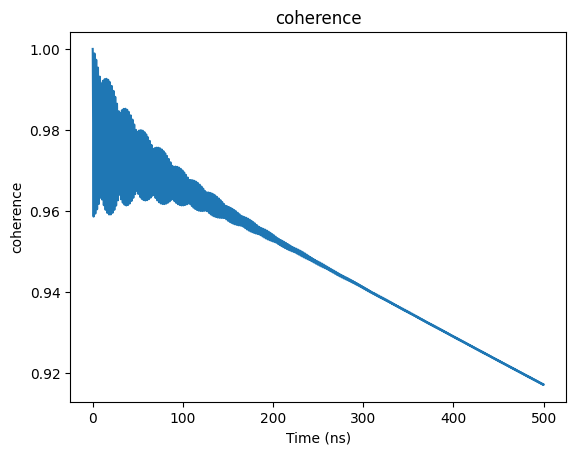

In [76]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

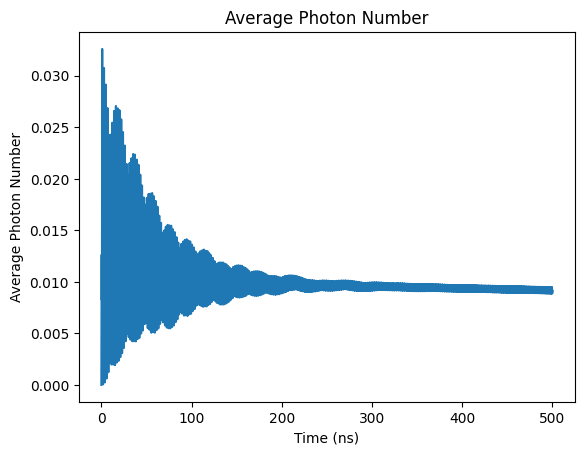

In [77]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

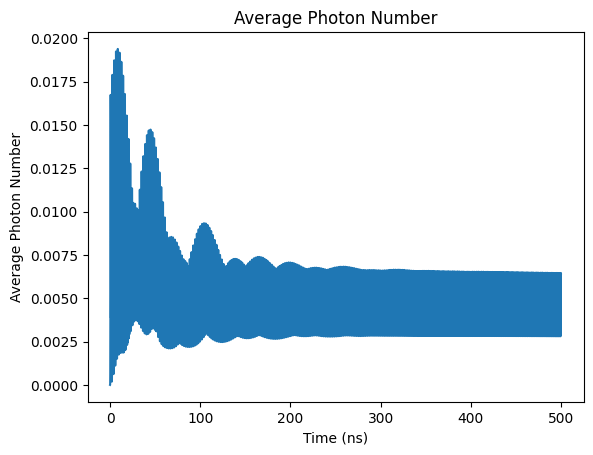

In [78]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

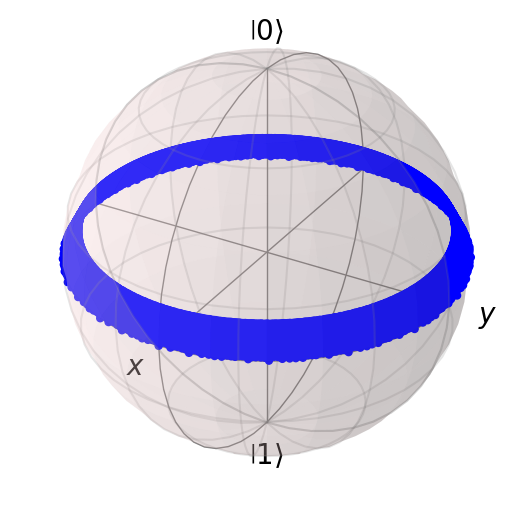

In [79]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.04 GHz)

In [80]:
# constant
N = 2

A = 0.04 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [81]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.01404443850917891


Text(0, 0.5, 'Z Expectation Value')

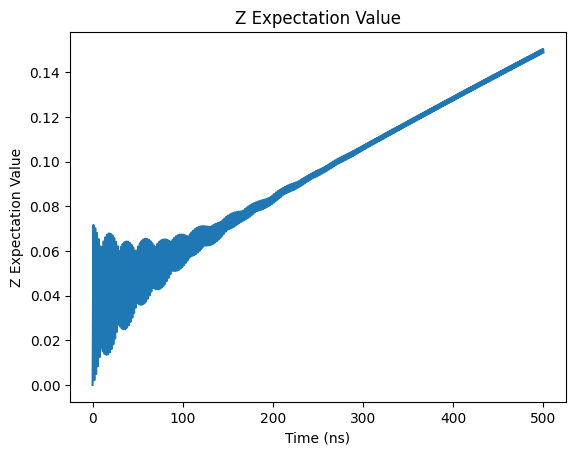

In [82]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [83]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-8.99043497e-01,  9.35472957e-01,  3.71443253e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

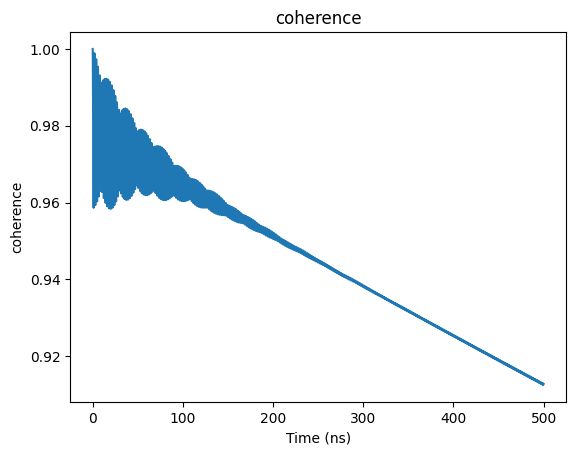

In [84]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

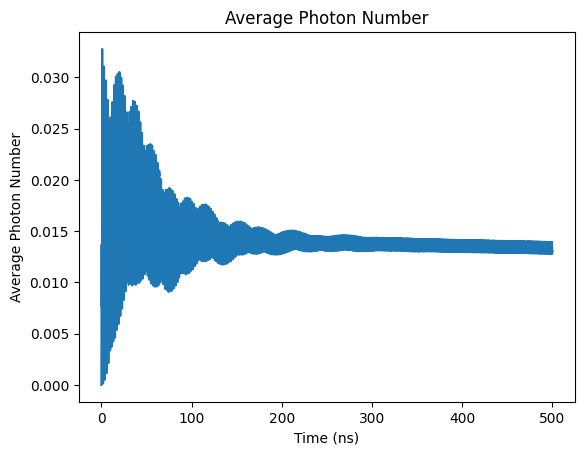

In [85]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

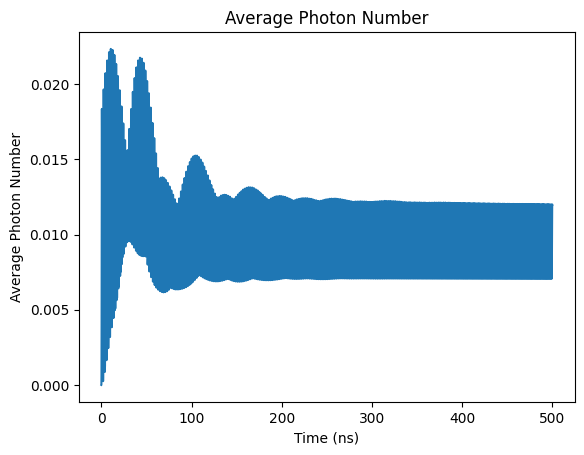

In [86]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

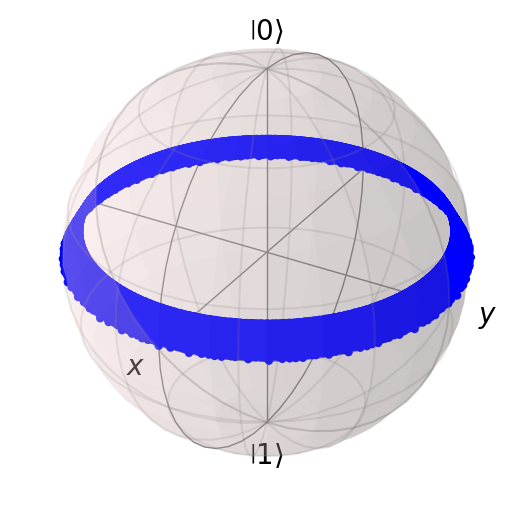

In [87]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.05 GHz)

In [88]:
# constant
N = 2

A = 0.05 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [89]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.022463949674930914


Text(0, 0.5, 'Z Expectation Value')

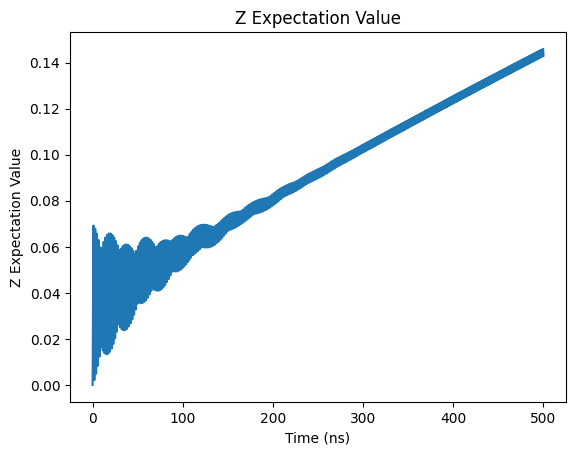

In [90]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [91]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-7.71085144e-01,  8.06152989e-01,  3.26680345e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

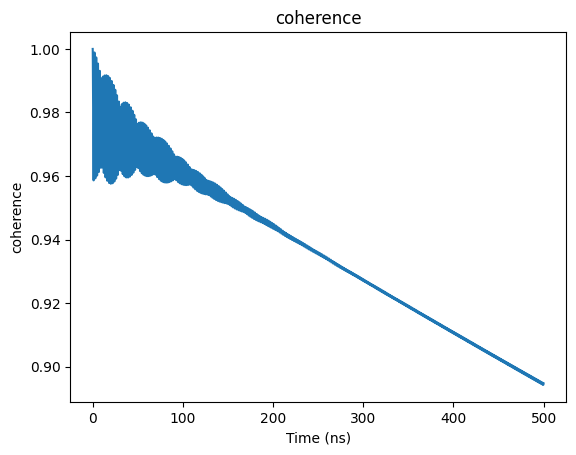

In [92]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

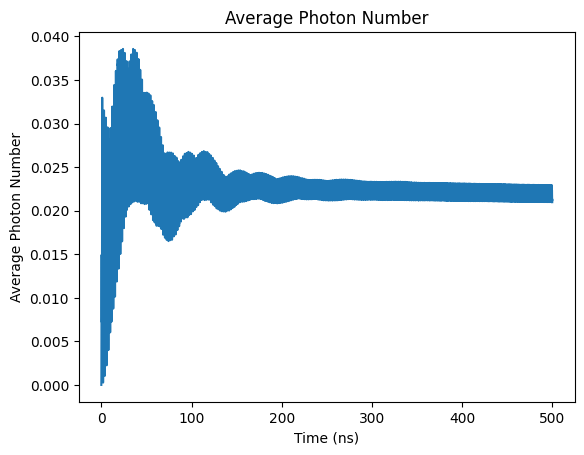

In [93]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

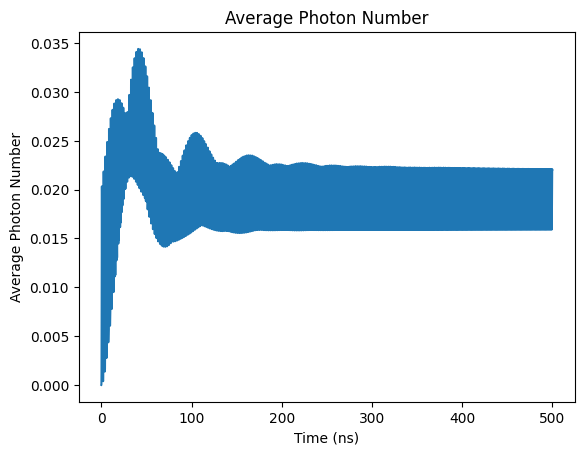

In [94]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

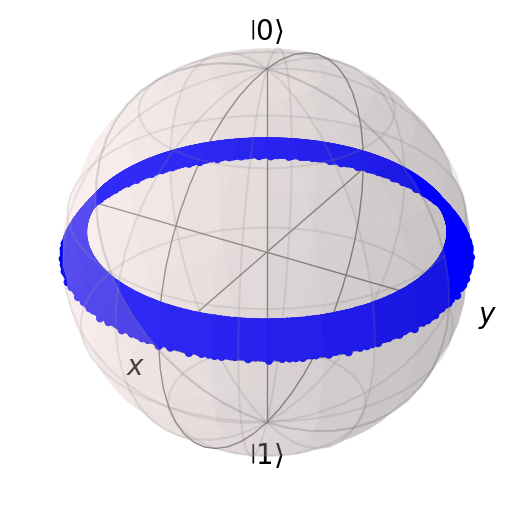

In [95]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.06 GHz)

In [96]:
# constant
N = 2

A = 0.06 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [97]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.03694191539012318


Text(0, 0.5, 'Z Expectation Value')

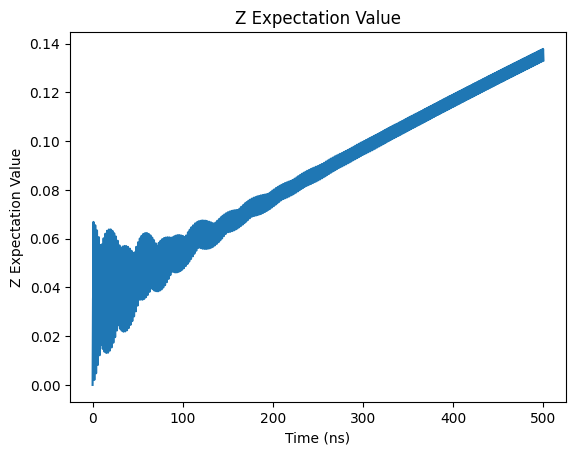

In [98]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [99]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-5.59887989e-01,  5.93355844e-01,  2.48690611e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

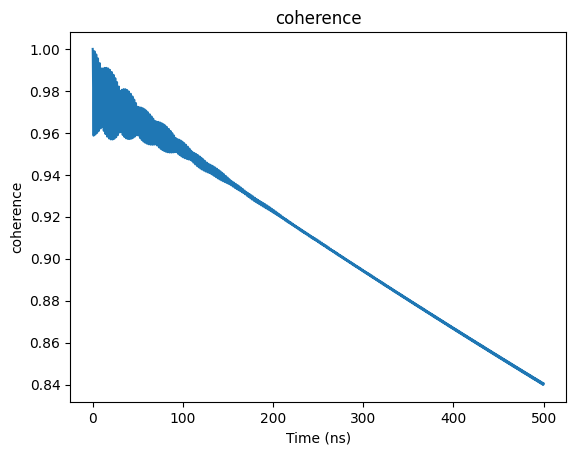

In [100]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

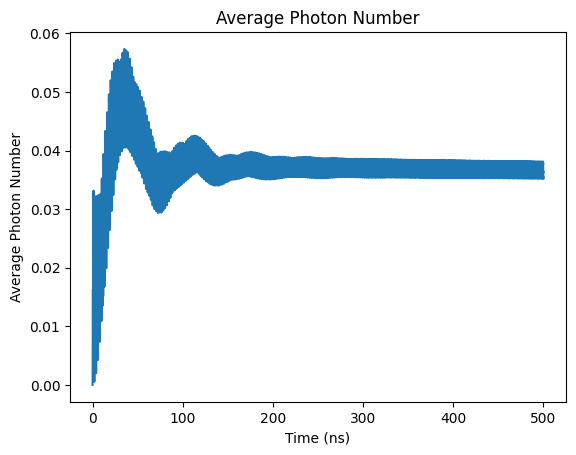

In [101]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

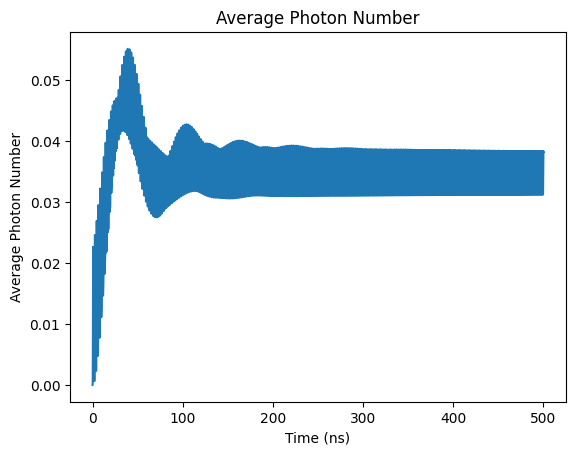

In [102]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

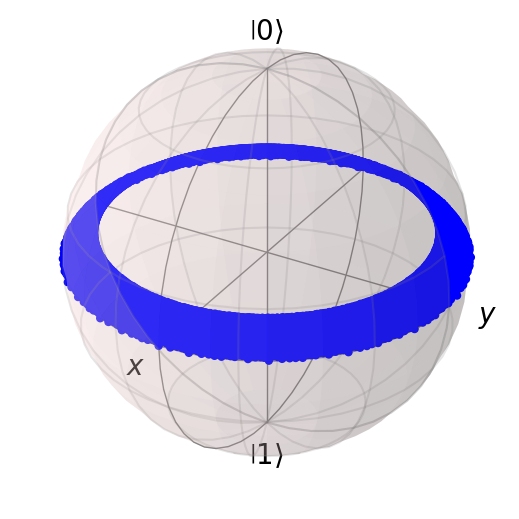

In [103]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.07 GHz)

In [104]:
# constant
N = 2

A = 0.07 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [105]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.05876942996147742


Text(0, 0.5, 'Z Expectation Value')

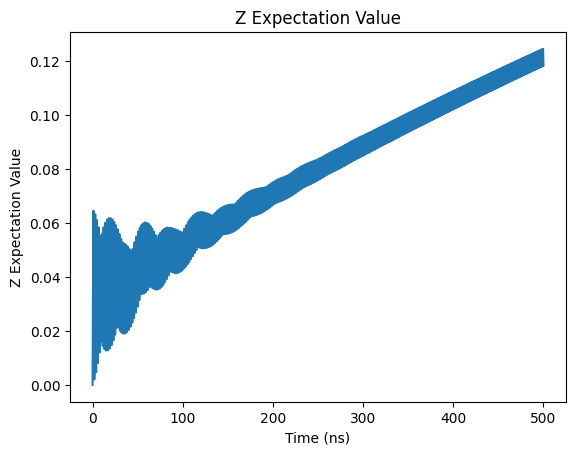

In [106]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [107]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-3.43469891e-01,  3.75028940e-01,  1.65089131e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

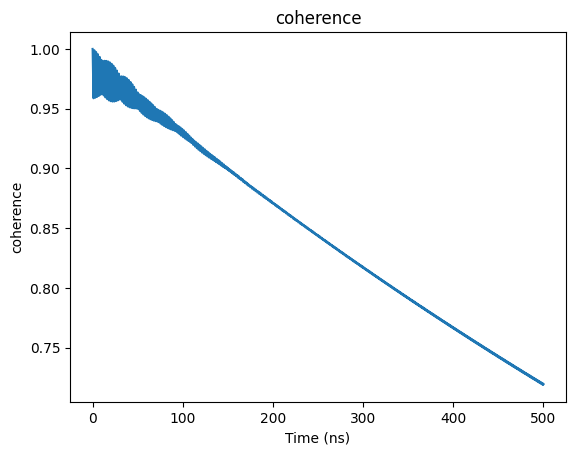

In [108]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

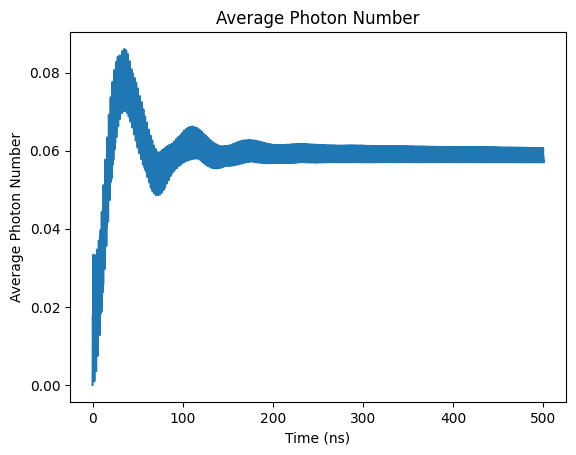

In [109]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

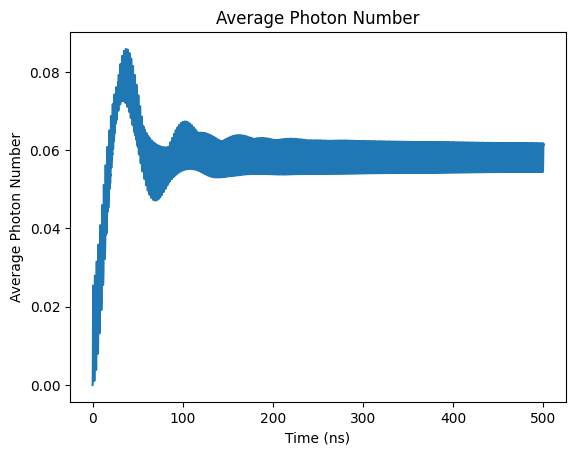

In [110]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

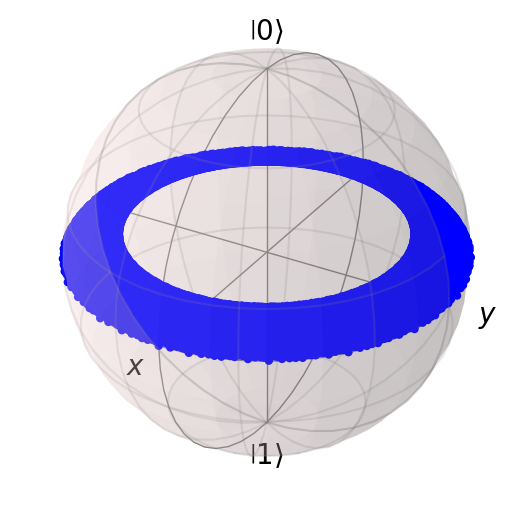

In [111]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.08 GHz)

In [112]:
# constant
N = 2

A = 0.08 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [113]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.08822084696907329


Text(0, 0.5, 'Z Expectation Value')

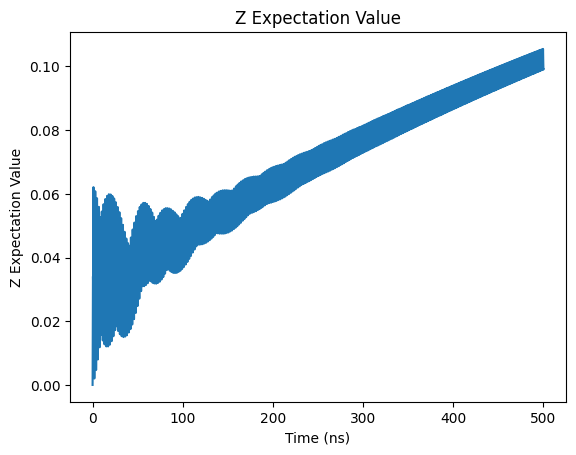

In [114]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [115]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.89110793e-01,  2.18426981e-01,  1.02715910e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

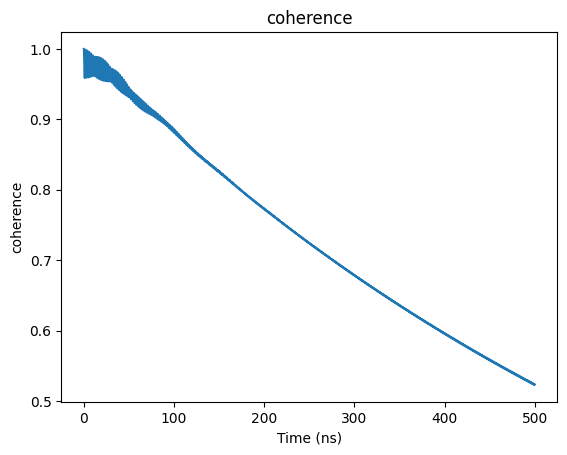

In [116]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

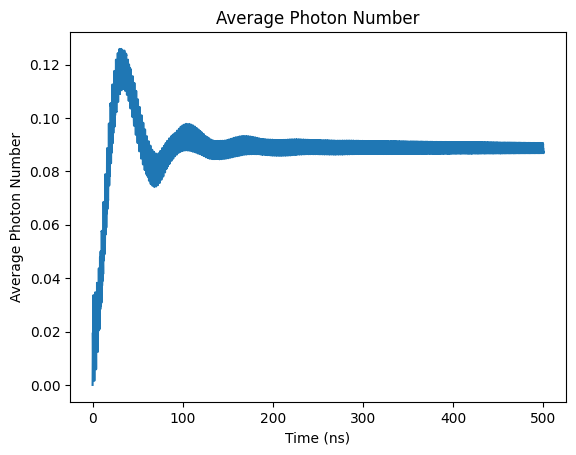

In [117]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

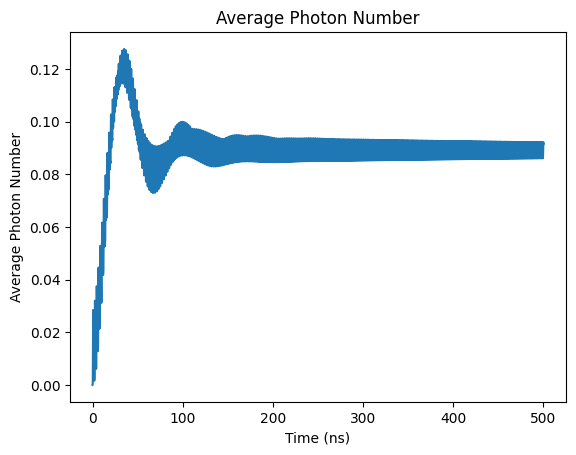

In [118]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

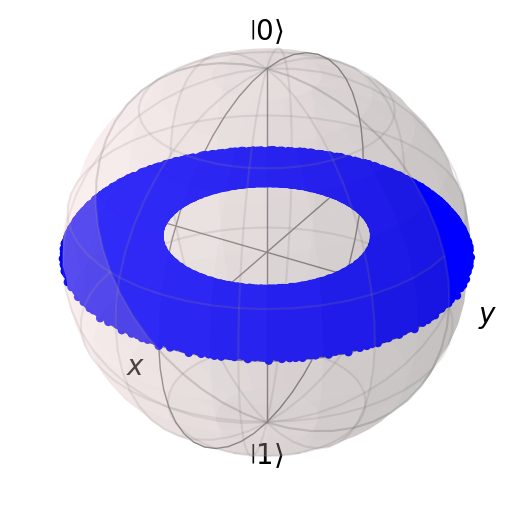

In [119]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.09 GHz)

In [120]:
# constant
N = 2

A = 0.09 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [121]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.12424001012449509


Text(0, 0.5, 'Z Expectation Value')

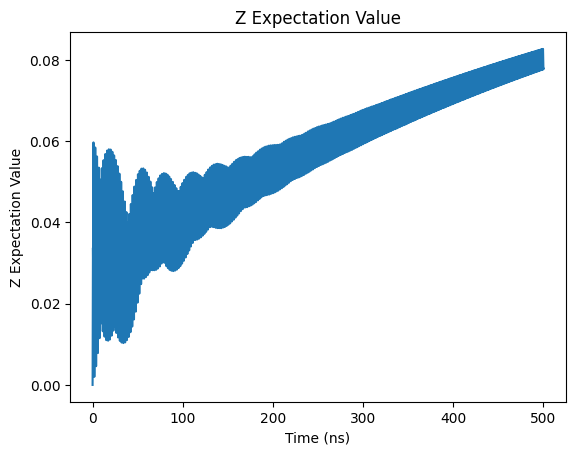

In [122]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [123]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.85478286e-02,  1.25331687e-01,  6.42073804e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

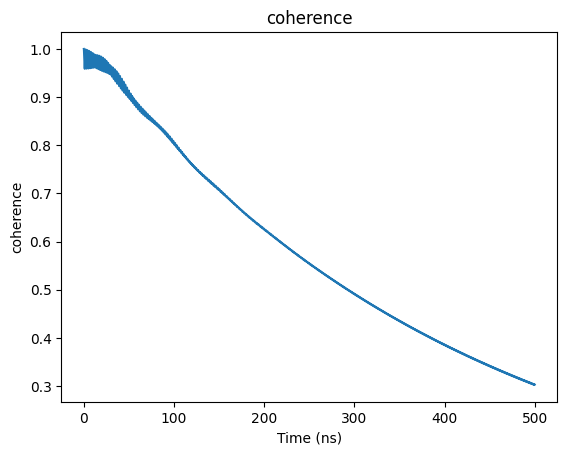

In [124]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

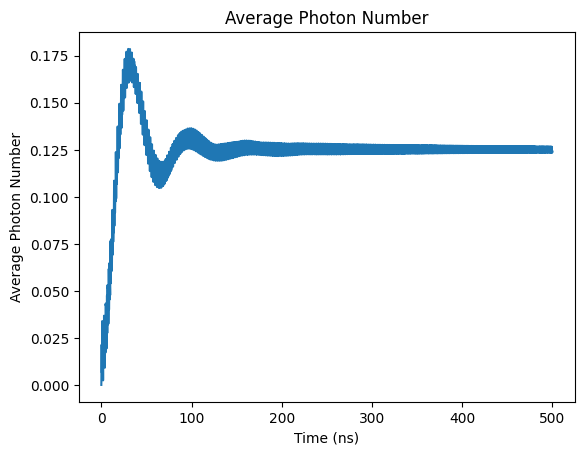

In [125]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

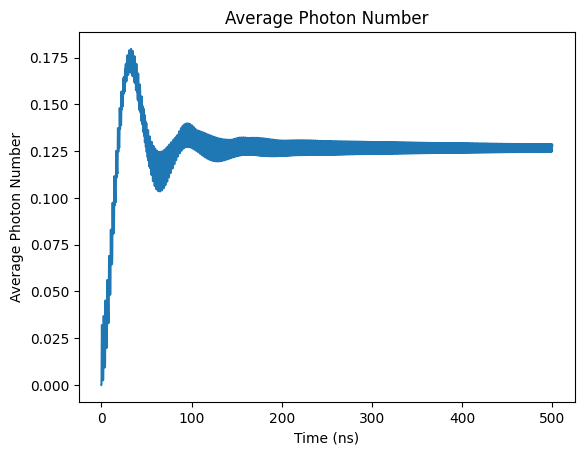

In [126]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

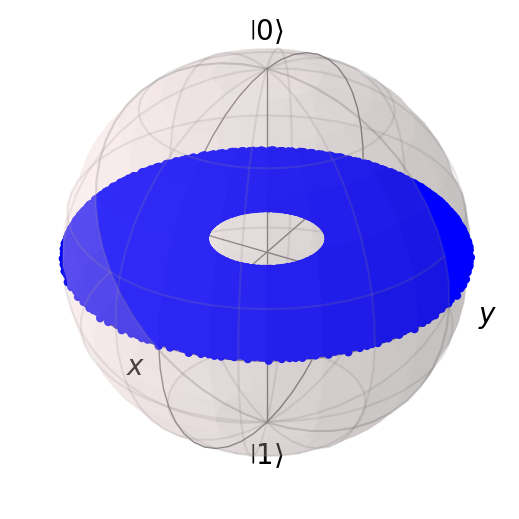

In [127]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.10 GHz)

In [128]:
# constant
N = 2

A = 0.10 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [129]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.1645887758015602


Text(0, 0.5, 'Z Expectation Value')

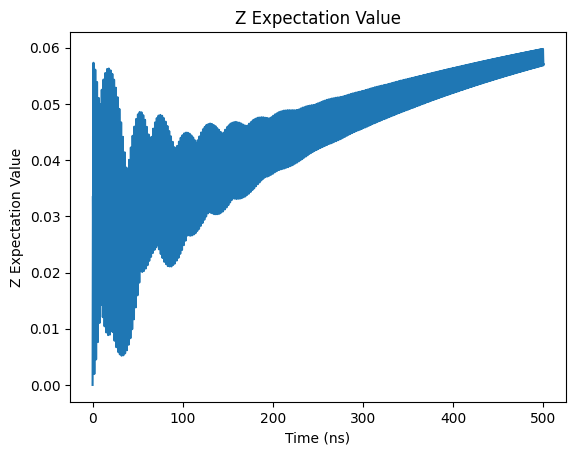

In [130]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [131]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-4.87526109e-02,  7.28350747e-02,  4.15984464e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

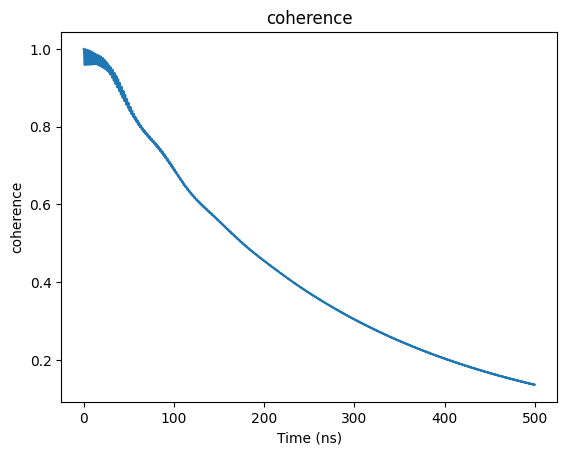

In [132]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

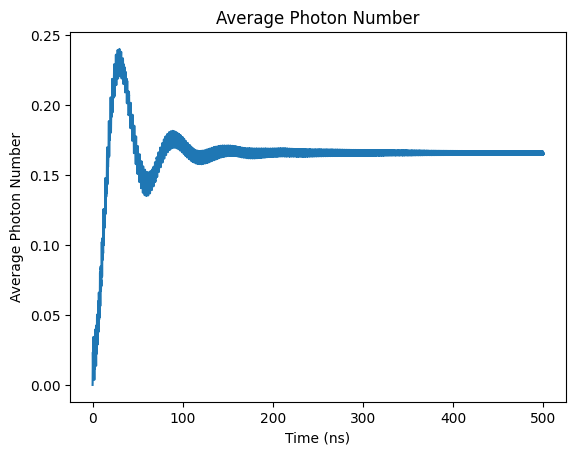

In [133]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

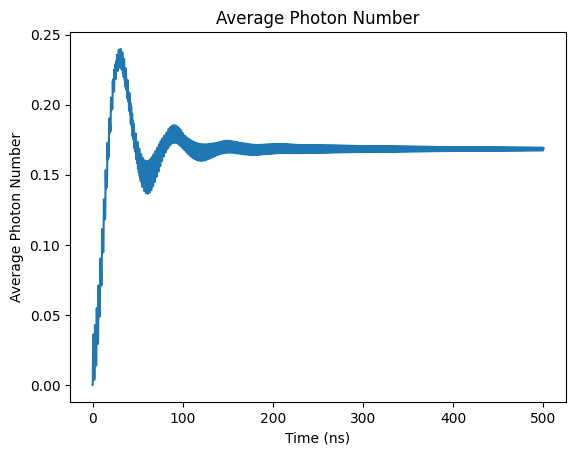

In [134]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

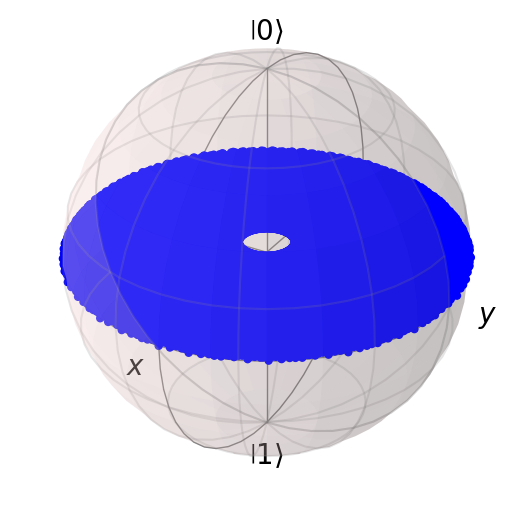

In [135]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.11 GHz)

In [136]:
# constant
N = 2

A = 0.11 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [137]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.2075442368201584


Text(0, 0.5, 'Z Expectation Value')

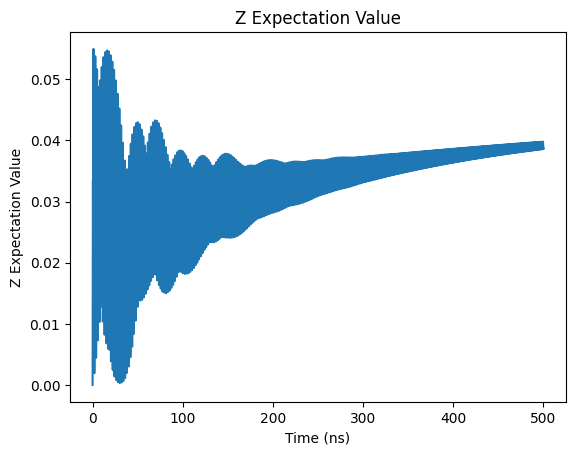

In [138]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [139]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-2.10403248e-02,  4.23772773e-02,  2.73554127e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

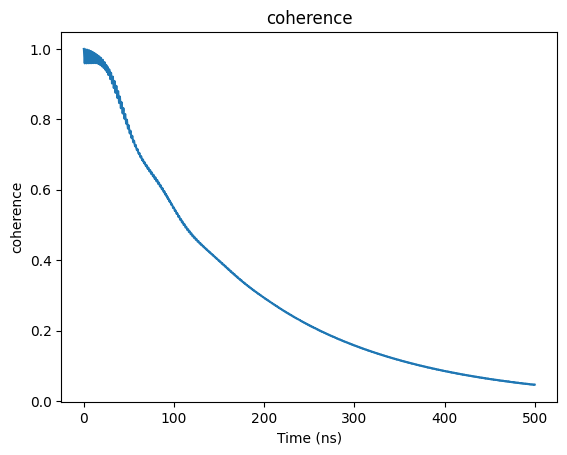

In [140]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

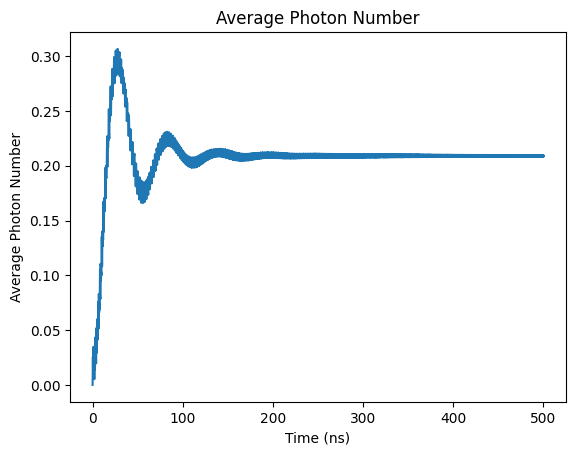

In [141]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

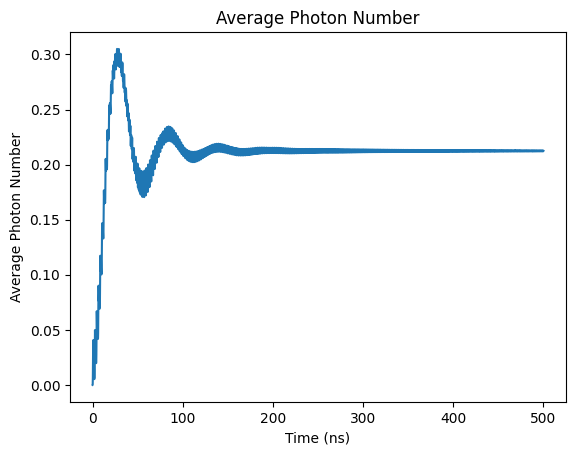

In [142]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

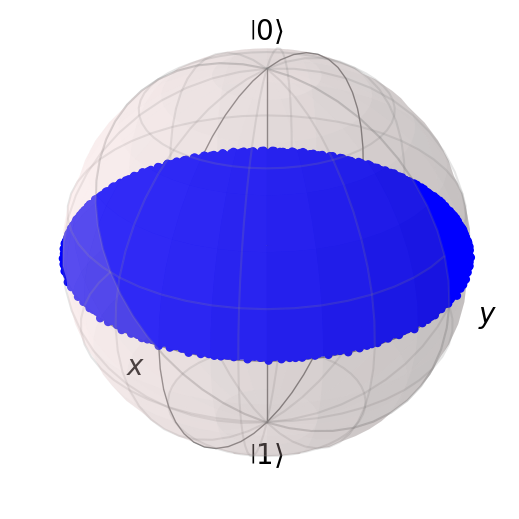

In [143]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.12 GHz)

In [144]:
# constant
N = 2

A = 0.12 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [145]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.24823480383925112


Text(0, 0.5, 'Z Expectation Value')

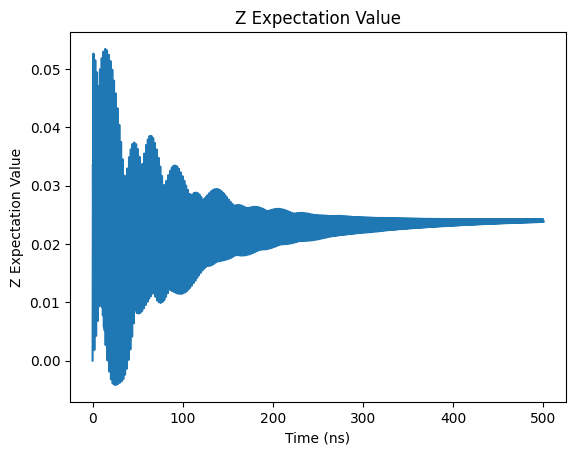

In [146]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [147]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-5.36487717e-03,  2.38776122e-02,  1.27799090e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

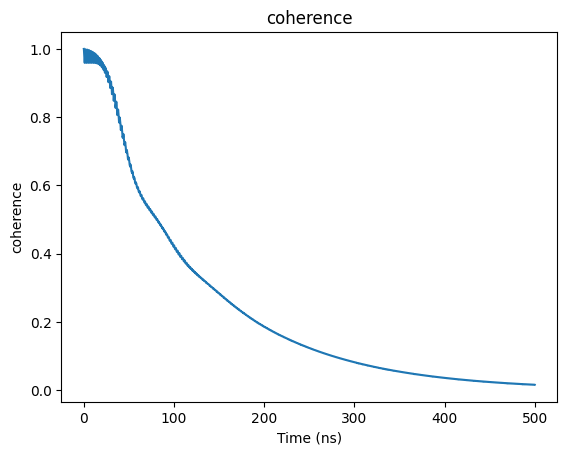

In [148]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

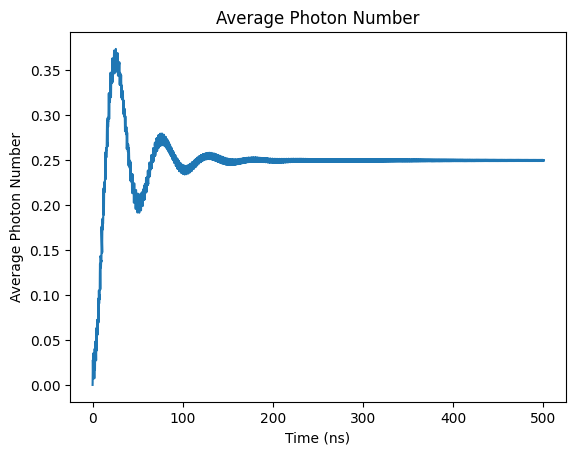

In [149]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

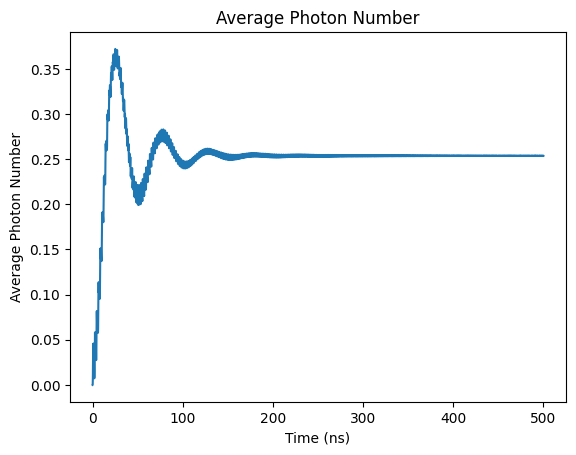

In [150]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

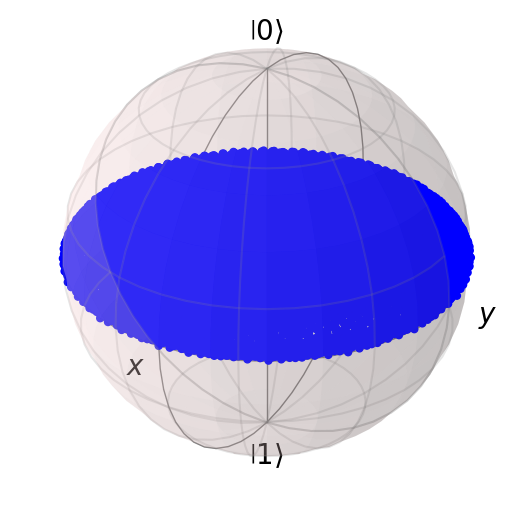

In [151]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.13 GHz)

In [152]:
# constant
N = 2

A = 0.13 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [153]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.2857583013724545


Text(0, 0.5, 'Z Expectation Value')

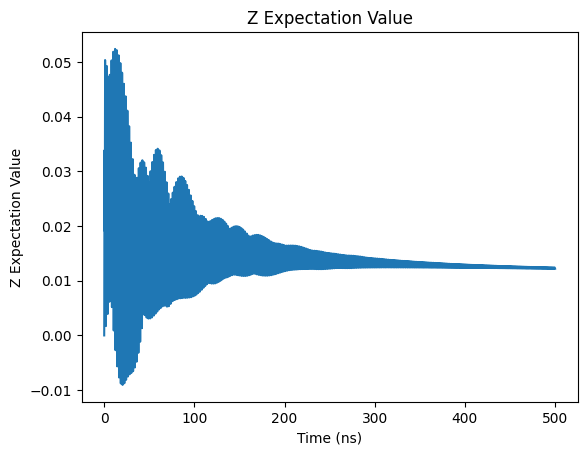

In [154]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [155]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([6.41460295e-03, 1.07906099e-02, 3.23697141e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

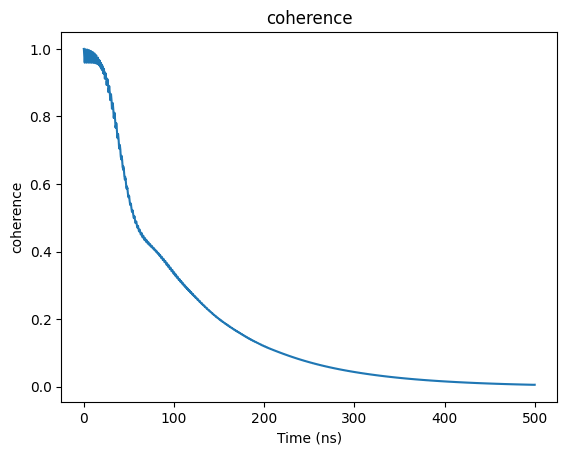

In [156]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

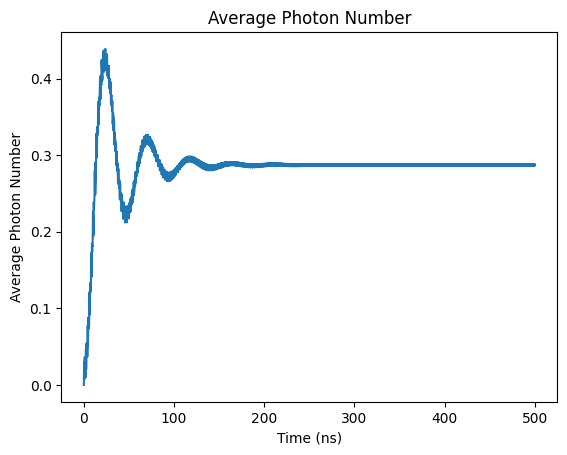

In [157]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

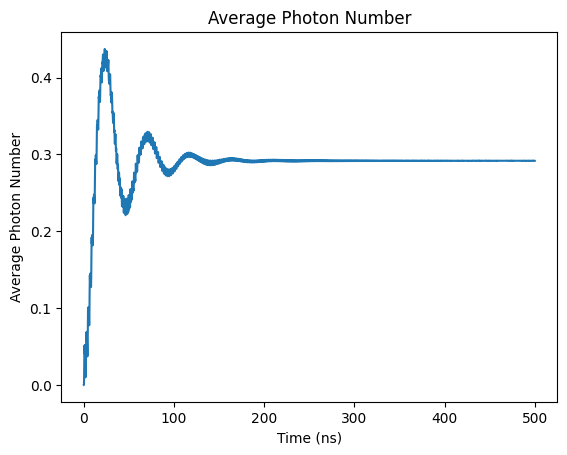

In [158]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

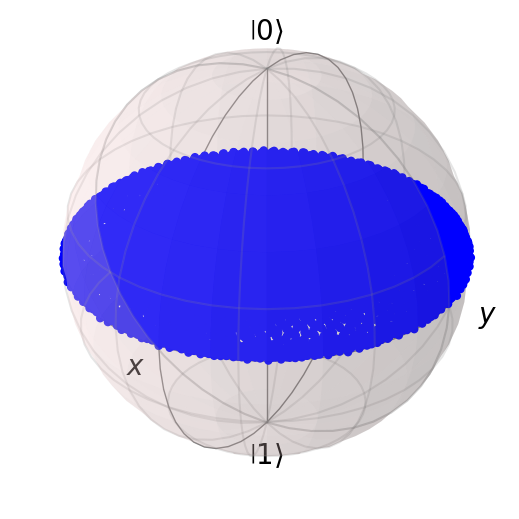

In [159]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.14 GHz)

In [160]:
# constant
N = 2

A = 0.14 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [161]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.31901806526561194


Text(0, 0.5, 'Z Expectation Value')

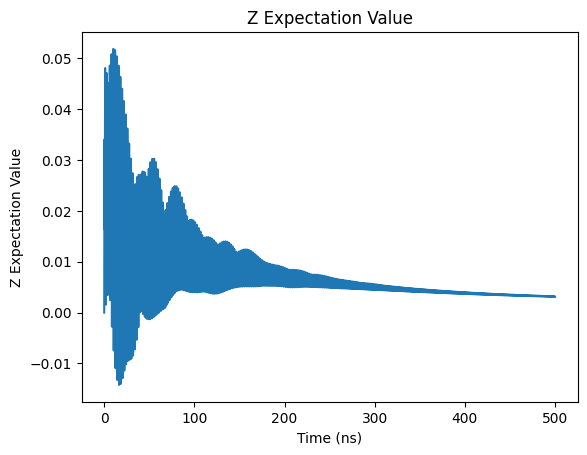

In [162]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [163]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([1.37950605e-02, 1.90276394e-03, 2.02480771e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

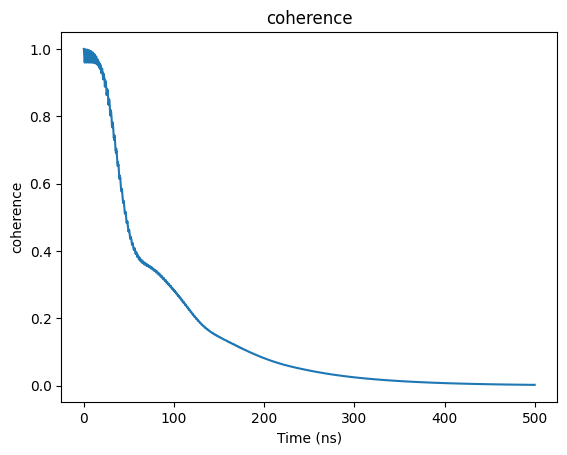

In [164]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

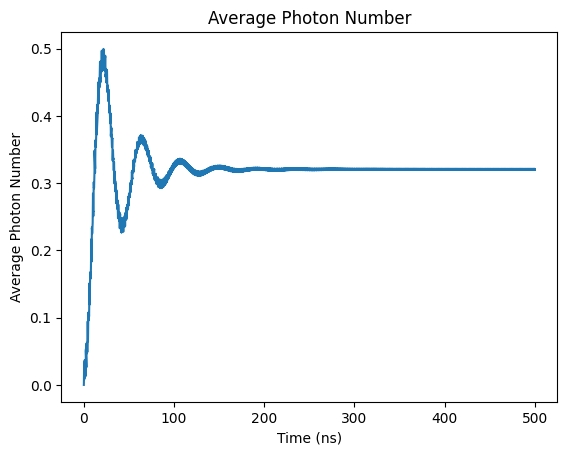

In [165]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

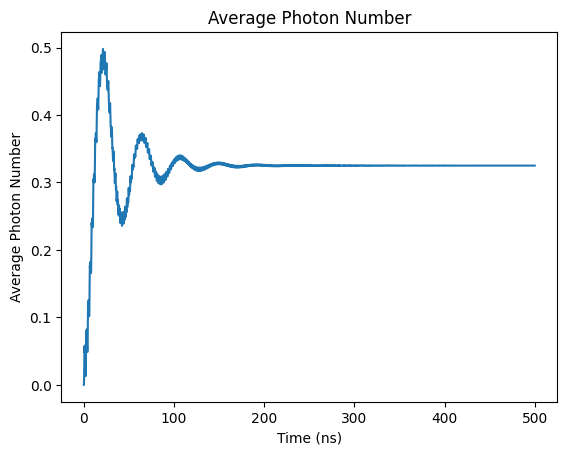

In [166]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

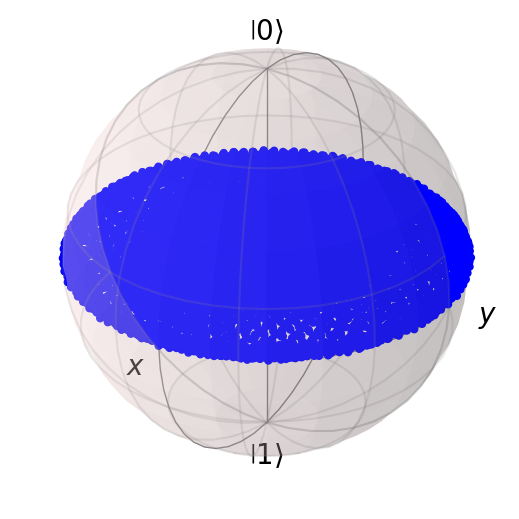

In [167]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (A = 0.15 GHz)

In [168]:
# constant
N = 2

A = 0.15 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [169]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.3476606670828996


Text(0, 0.5, 'Z Expectation Value')

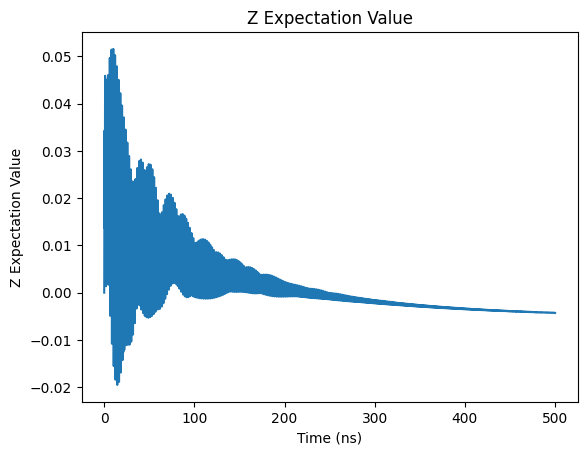

In [170]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [171]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([ 2.00559921e-02, -5.31914092e-03,  1.69216773e+02])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

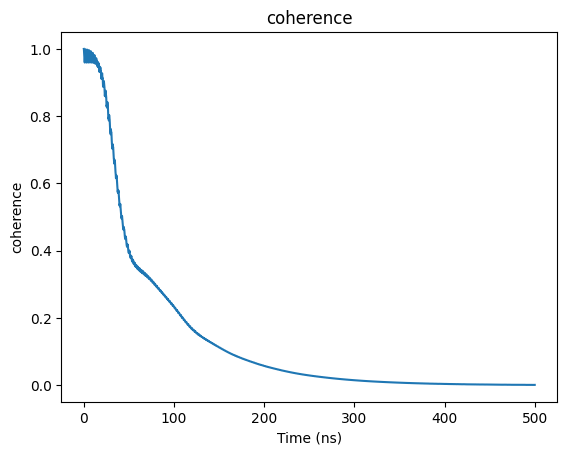

In [172]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

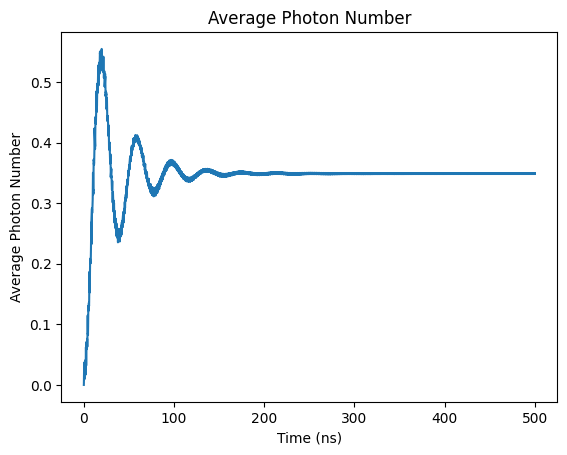

In [173]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

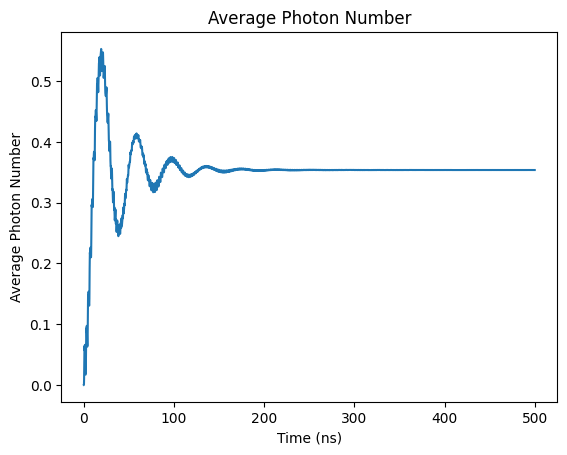

In [174]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

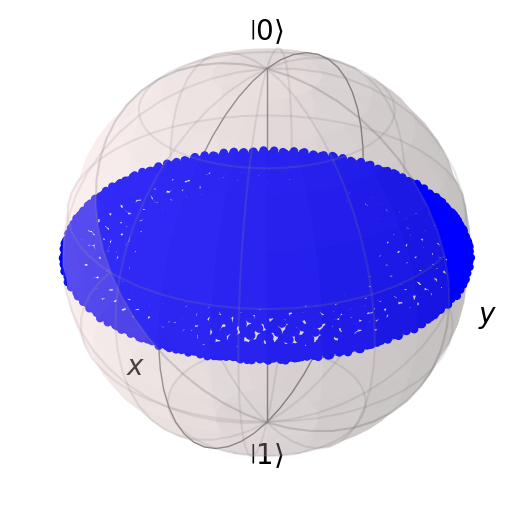

In [175]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

# Dynamical Decoupling Bloch Sphere Approach

With Purcell Filter

Evolution time 500ns

In [214]:
tot_coherence_list = []

## Readout Resonator Amplitude $ A = 0.00GHz $

Readout Resonator Photon number $ n = 0.007985 $

Evolution time 500ns

In [215]:
# constant
N = 2

A = 0.00 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [216]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.00798522851099307


Text(0, 0.5, 'Z Expectation Value')

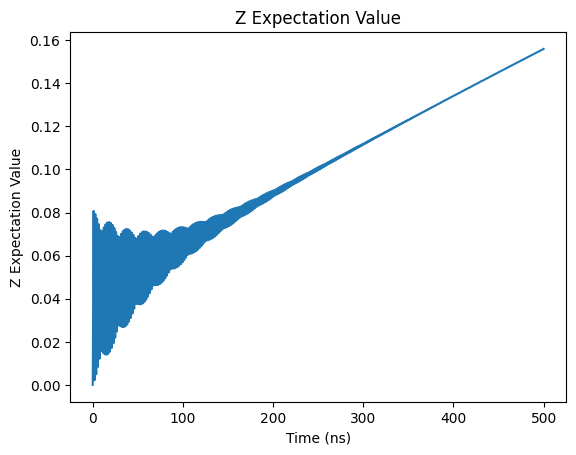

In [217]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [218]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.54845817e-01,  9.95871091e-01,  3.89892242e+03])

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

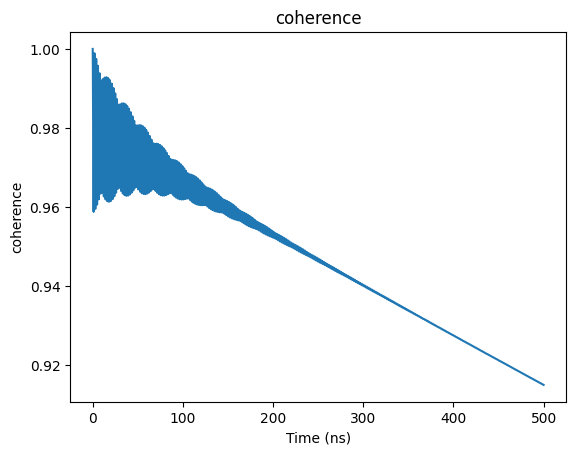

In [219]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

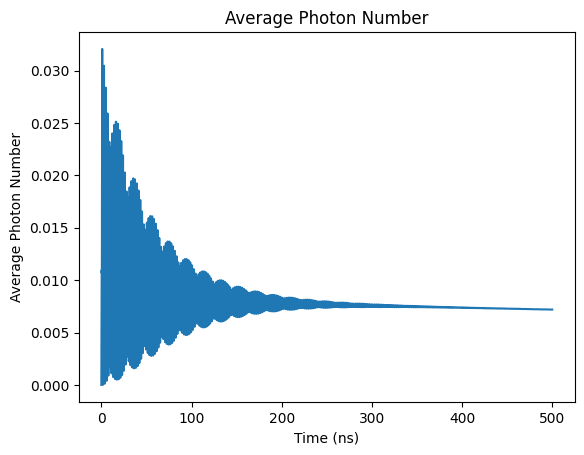

In [220]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

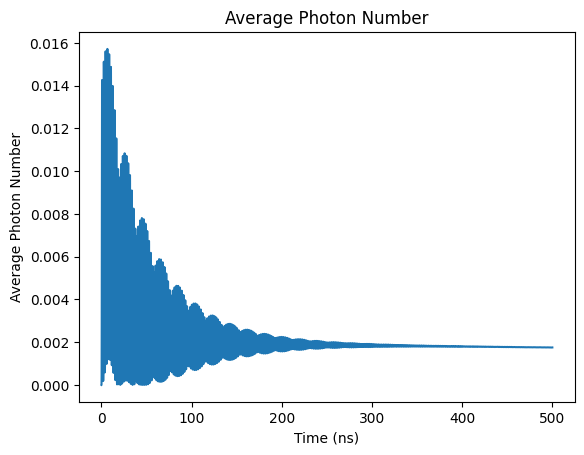

In [221]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

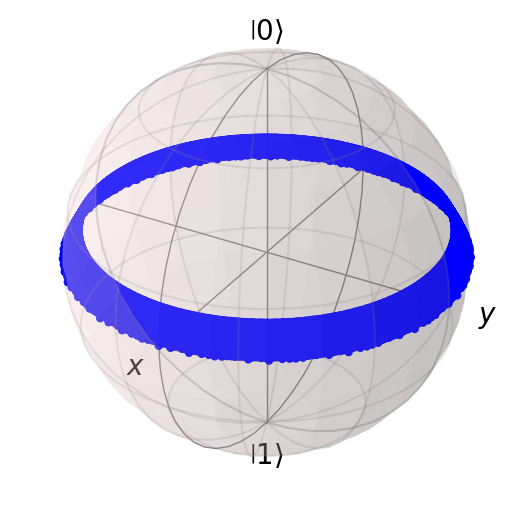

In [222]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [223]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [224]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.00869468842201558


Text(0, 0.5, 'Z Expectation Value')

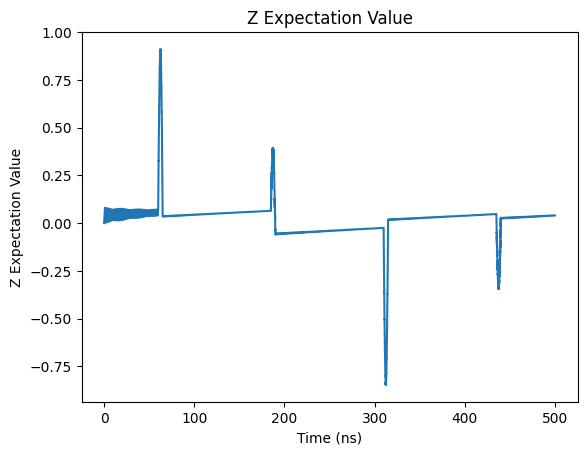

In [225]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

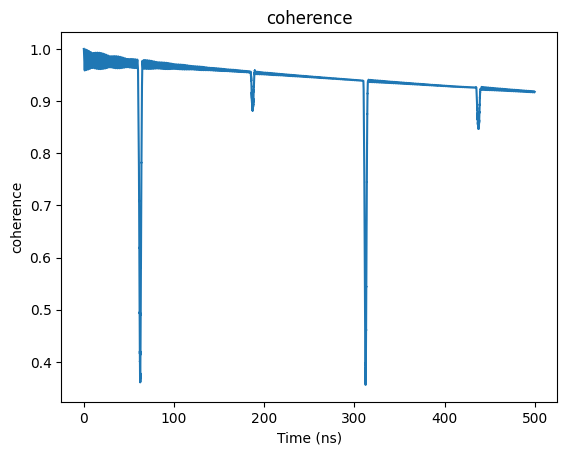

In [226]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

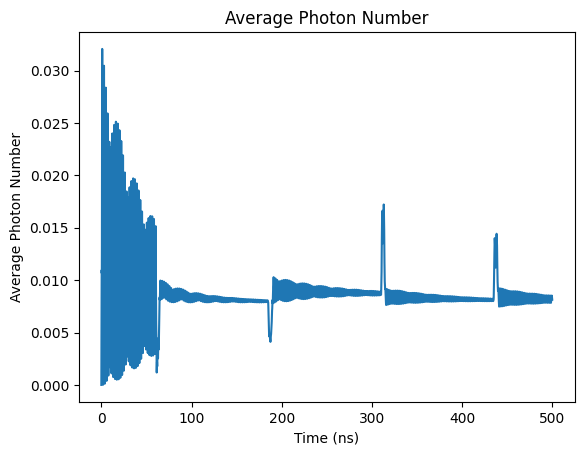

In [227]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

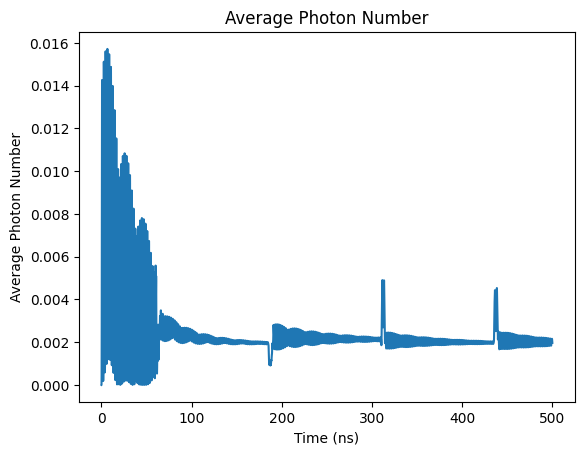

In [228]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

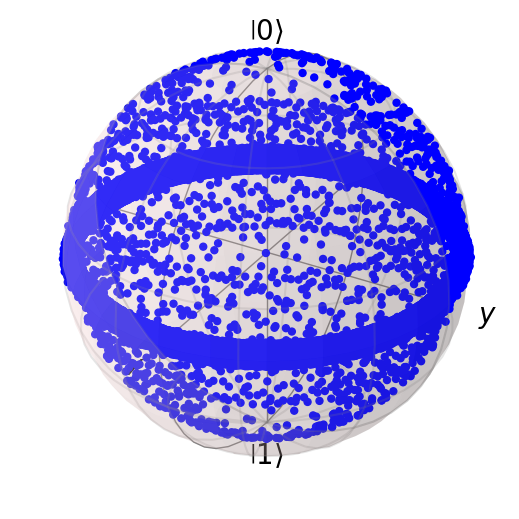

In [229]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [230]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [231]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.008728403410150787


Text(0, 0.5, 'Z Expectation Value')

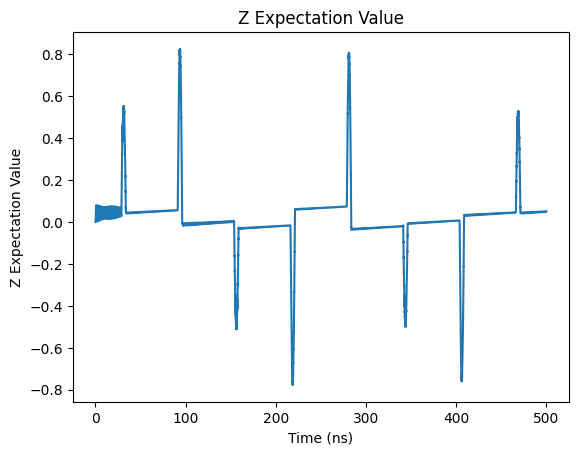

In [232]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

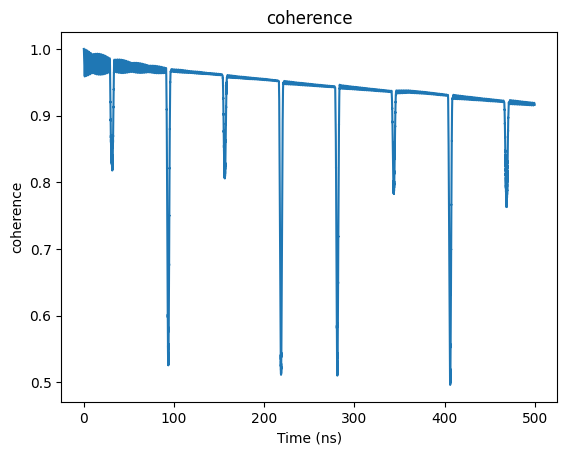

In [233]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

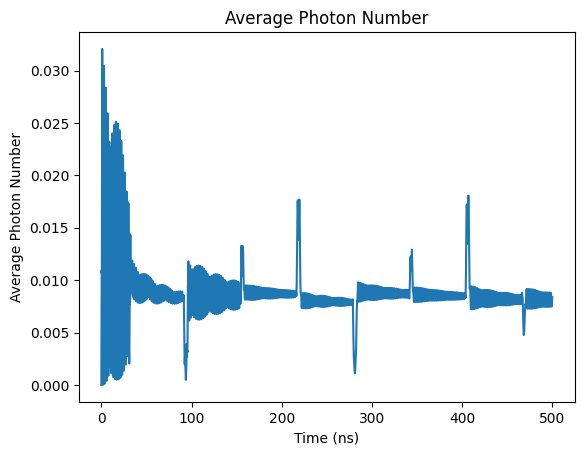

In [234]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

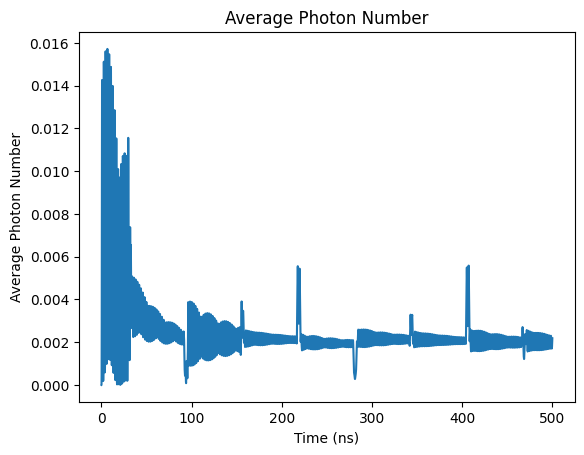

In [235]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

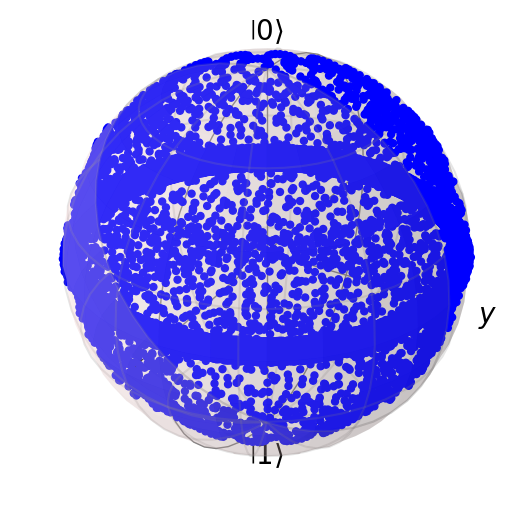

In [236]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [237]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [238]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.008746443891765767


Text(0, 0.5, 'Z Expectation Value')

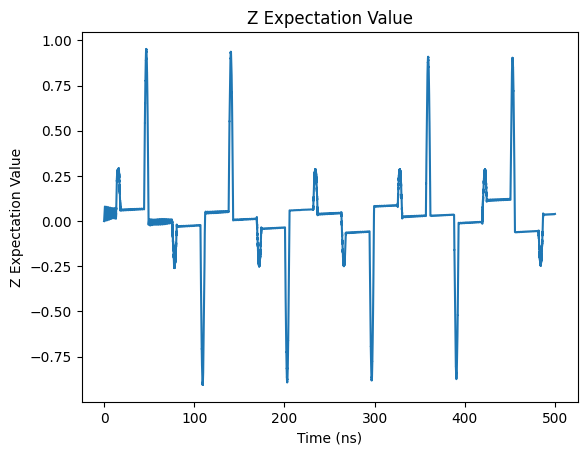

In [239]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

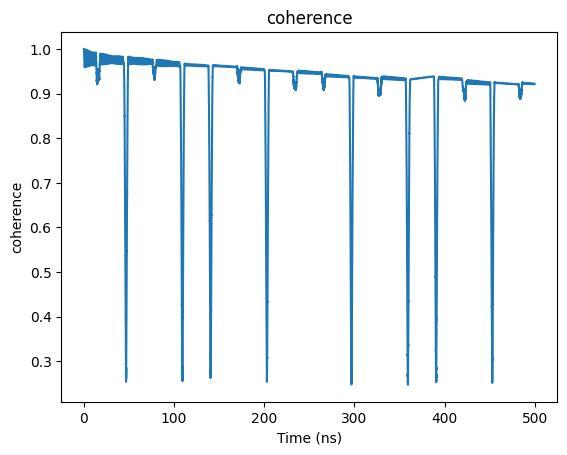

In [240]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

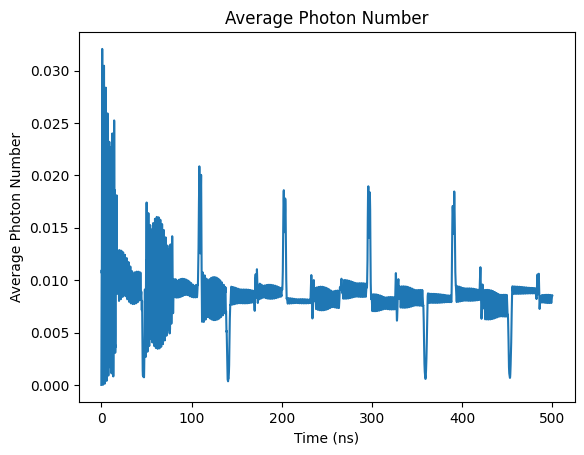

In [241]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

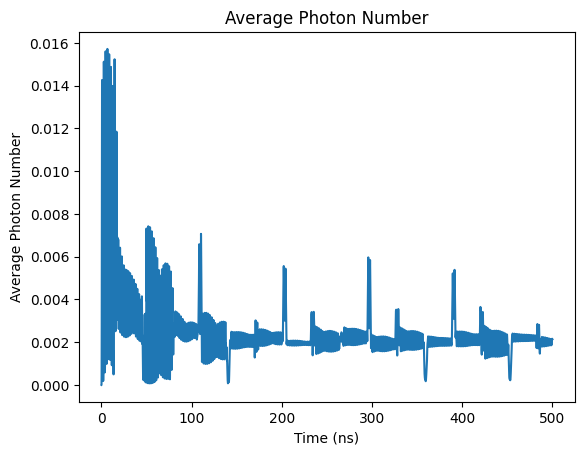

In [242]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

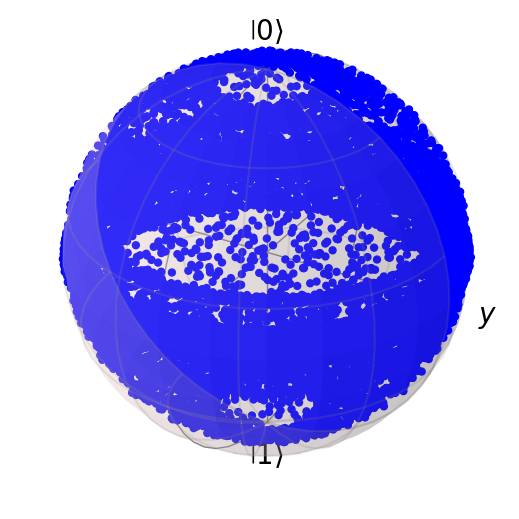

In [243]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [244]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [245]:
coherence_list

[0.9150321263157126,
 0.9170425324838004,
 0.9183233636129248,
 0.9211155390771676]

In [246]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.01GHz $

Readout Resonator Photon number $ n = 0.008004 $

Evolution time 500ns

In [247]:
# constant
N = 2

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500


A = 0.01 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.02GHz $

Readout Resonator Photon number $ n = 0.008364 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.02 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.03GHz $

Readout Resonator Photon number $ n = 0.009921 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.03 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.04GHz $

Readout Resonator Photon number $ n = 0.014044 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.04 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.05GHz $

Readout Resonator Photon number $ n = 0.022463 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.05 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.06GHz $

Readout Resonator Photon number $ n = 0.036942 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.06 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.07GHz $

Readout Resonator Photon number $ n = 0.058769 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.07 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.08GHz $

Readout Resonator Photon number $ n = 0.088220 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.08 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator Amplitude $ A = 0.09GHz $

Readout Resonator Photon number $ n = 0.124240 $

Evolution time 500ns

In [ ]:
# constant
N = 2

A = 0.09 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)